# ***Load Data***

In [1]:
import geopandas as gpd
import pandas as pd
from openpyxl import load_workbook
from shapely.geometry import Polygon
import numpy as np

In [2]:
# Load the shapefile
S = gpd.read_file('CA_Counties_TIGER2016.shp')

In [3]:
# Load the EV registration data
regData = pd.read_csv('CA_EV_registration.csv', low_memory=False)

In [4]:
regData

,Vehicle ID,County GEOID,Registration Valid Date,DMV ID,DMV Snapshot,Registration Expiration Date,State Abbreviation,Geography,Vehicle Name
0,CA-002-03597\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Chevrolet Volt
1,CA-002-03598\r,06105,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Nissan Leaf
2,CA-002-03599\r,06103,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Chevrolet Volt
3,CA-002-03600\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Tesla Roadster
4,CA-002-03601\r,06099,2011-01-01,2,CA Registration Data from CA (12/31/2011),NaN,CA,County,Tesla Roadster
...,...,...,...,...,...,...,...,...,...
2542438,CA-011-471900\r,06075,2020-01-01,11,CA Registration Data from CA (12/31/2020),NaN,CA,County,Toyota Prius Plug-in
2542439,CA-011-471901\r,06075,2020-01-01,11,CA Registration Data from CA (12/31/2020),NaN,CA,County,Toyota Prius Plug-in
2542440,CA-011-471902\r,06075,2020-01-01,11,CA Registration Data from CA (12/31/2020),NaN,CA,County,Toyota Prius Plug-in
2542441,CA-011-471903\r,06075,2020-01-01,11,CA Registration Data from CA (12/31/2020),NaN,CA,County,Toyota Prius Plug-in


In [5]:
# Remove rows with 'Unknown' in 'County GEOID' column
regData = regData[regData['County GEOID'] != 'Unknown']

# Now convert 'County GEOID' column to integer
regData['County GEOID'] = regData['County GEOID'].astype(int)

C:\Users\guota\AppData\Local\Temp\ipykernel_8028\4274765944.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regData['County GEOID'] = regData['County GEOID'].astype(int)


In [6]:
regData['Registration Valid Date'] = pd.to_datetime(regData['Registration Valid Date'])
regData['Year'] = regData['Registration Valid Date'].dt.year

C:\Users\guota\AppData\Local\Temp\ipykernel_8028\2096542235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regData['Registration Valid Date'] = pd.to_datetime(regData['Registration Valid Date'])
C:\Users\guota\AppData\Local\Temp\ipykernel_8028\2096542235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regData['Year'] = regData['Registration Valid Date'].dt.year


In [7]:
# Summarize the registration data by CountyGEOID and Year
summaryRegData = regData.groupby(['County GEOID', 'Year']).size().reset_index(name='Group Count')

In [8]:
# Then, unstack the 'GroupCount' data
reshapedRegData = summaryRegData.pivot(index='County GEOID', columns='Year', values='Group Count').reset_index()
reshapedRegData.columns.name = None

In [9]:
# Replace NaNs with zeros
reshapedRegData.fillna(0, inplace=True)

In [10]:
# Compute the total registrations for each 'CountyGEOID'
reshapedRegData['Total'] = reshapedRegData.iloc[:, 1:].sum(axis=1)

In [11]:
# Find centroids for each county
S['Centroid_X'] = S['geometry'].centroid.x
S['Centroid_Y'] = S['geometry'].centroid.y

In [12]:
# Convert 'GEOID' to int32 type
S['GEOID'] = S['GEOID'].astype('int32')

# Merge reshapedRegData with S based on the common key 'CountyGEOID'
mergedData = pd.merge(reshapedRegData, S, left_on='County GEOID', right_on='GEOID')

In [13]:
# Define an array of quarters and an array of years
quarters = ['Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4']
years = [2020, 2020, 2020, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022]  # Repeat each year 4 times except the first and the last year

# Loop over the quarters and years to read chargerData
wb = load_workbook(filename = 'EV_Chargers_Last_updated_03-20-2023_ada.xlsx')

In [14]:
# Initialize chargerData with the first sheet
sheetName = quarters[0] + ' ' + str(years[0])
data = wb[sheetName].values
chargerData = pd.DataFrame(data)
chargerData.columns = chargerData.iloc[0]
chargerData = chargerData.iloc[1:]

# Rename the columns in chargerData except for 'County'
chargerData.columns = chargerData.columns.map(lambda x: f"{sheetName}-{x}" if x != 'County' else x)

# Ensure 'County' column is of the same data type
chargerData['County'] = chargerData['County'].astype(str)

# Iterate over the remaining sheets
for i in range(1, len(years)):
    sheetName = quarters[i] + ' ' + str(years[i])
    data = wb[sheetName].values
    temp_df = pd.DataFrame(data)
    temp_df.columns = temp_df.iloc[0]
    temp_df = temp_df.iloc[1:]
    
    # Rename the columns in temp_df except for 'County'
    temp_df.columns = temp_df.columns.map(lambda x: f"{sheetName}-{x}" if x != 'County' else x)
    
    # Ensure 'County' column is of the same data type
    temp_df['County'] = temp_df['County'].astype(str)
    
    # Merge the temporary DataFrame onto chargerData on 'County'
    chargerData = pd.merge(chargerData, temp_df, on='County')

# Merge chargerData with mergedData using 'County' as the key
finalMergedData = pd.merge(mergedData, chargerData, left_on='NAME', right_on='County')



In [15]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

finalMergedData


,County GEOID,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Centroid_X,Centroid_Y,County,Q2 2020-Public Level 1,Q2 2020-Shared Private Level 1,Q2 2020-Public Level 2,Q2 2020-Shared Private Level 2,Q2 2020-Public DC Fast,Q2 2020-Shared Private DC Fast,Q2 2020-Total,Q3 2020-Public Level 1,Q3 2020-Shared Private Level 1,Q3 2020-Public Level 2,Q3 2020-Shared Private Level 2,Q3 2020-Public DC Fast,Q3 2020-Shared Private DC Fast,Q3 2020-Total,Q4 2020-Public Level 1,Q4 2020-Shared Private Level 1,Q4 2020-Public Level 2,Q4 2020-Shared Private Level 2,Q4 2020-Public DC Fast,Q4 2020-Shared Private DC Fast,Q4 2020-Total,Q1 2021-Public Level 1,Q1 2021-Shared Private Level 1,Q1 2021-Public Level 2,Q1 2021-Shared Private Level 2,Q1 2021-Public DC Fast,Q1 2021-Shared Private DC Fast,Q1 2021-Total,Q2 2021-Public Level 1,Q2 2021-Shared Private Level 1,Q2 2021-Public Level 2,Q2 2021-Shared Private Level 2,Q2 2021-Public DC Fast,Q2 2021-Shared Private DC Fast,Q2 2021-Total,Q3 2021-Public Level 1,Q3 2021-Shared Private Level 1,Q3 2021-Public Level 2,Q3 2021-Shared Private Level 2,Q3 2021-Public DC Fast,Q3 2021-Shared Private DC Fast,Q3 2021-Total,Q4 2021-Public Level 1,Q4 2021-Shared Private Level 1,Q4 2021-Public Level 2,Q4 2021-Shared Private Level 2,Q4 2021-Public DC Fast,Q4 2021-Shared Private DC Fast,Q4 2021-Total,Q1 2022-Public Level 1,Q1 2022-Shared Private Level 1,Q1 2022-Public Level 2,Q1 2022-Shared Private Level 2,Q1 2022-Public DC Fast,Q1 2022-Shared Private DC Fast,Q1 2022-Total,Q2 2022-Public Level 1,Q2 2022-Shared Private Level 1,Q2 2022-Public Level 2,Q2 2022-Shared Private Level 2,Q2 2022-Public DC Fast,Q2 2022-Shared Private DC Fast,Q2 2022-Total,Q3 2022-Public Level 1,Q3 2022-Shared Private Level 1,Q3 2022-Public Level 2,Q3 2022-Shared Private Level 2,Q3 2022-Public DC Fast,Q3 2022-Shared Private DC Fast,Q3 2022-Total,Q4 2022-Public Level 1,Q4 2022-Shared Private Level 1,Q4 2022-Public Level 2,Q4 2022-Shared Private Level 2,Q4 2022-Public DC Fast,Q4 2022-Shared Private DC Fast,Q4 2022-Total
0,6001,20.0,362.0,1168.0,3622.0,8304.0,13197.0,18116.0,24758.0,34389.0,42451.0,45785.0,192172.0,06,001,01675839,6001,Alameda,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,+37.6471385,-121.9124880,"POLYGON ((-13612246.763 4538150.085, -13612346...",-1.357185e+07,4.530207e+06,Alameda,14,14,1274,1398,258,32,2990,14,14,1288,1460,268,38,3082,14,14,1519,1472,296,38,3353,14,63,1635,1497,292,43,3544,14,63,1633,1497,310,43,3560,14,66,1633,1554,315,43,3625,6,70,1671,1583,332,35,3697,0,70,1671,2080,347,34,5051,0,70,1724,2104,366,34,5139,0,70,1465,2334,375,38,4282,4,66,1473,2465,385,37,4430
1,6003,0.0,0.0,0.0,2.0,5.0,3.0,4.0,3.0,4.0,6.0,11.0,38.0,06,003,01675840,6003,Alpine,Alpine County,06,H1,G4020,NaN,NaN,NaN,A,1912292633,12557304,+38.6217831,-119.7983522,"POLYGON ((-13366503.508 4678946.015, -13366492...",-1.333838e+07,4.664193e+06,Alpine,0,0,12,0,0,0,12,0,0,12,1,0,0,13,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,0,0,0,14,0,0,18,0,0,0,18,0,0,16,0,0,0,16,0,0,16,0,0,0,16,0,0,6,0,0,0,6
2,6005,1.0,6.0,8.0,9.0,21.0,44.0,58.0,92.0,128.0,175.0,226.0,768.0,06,005,01675841,6005,Amador,Amador County,06,H1,G4020,NaN,NaN,NaN,A,1539933576,29470568,+38.4435501,-120.6538563,"POLYGON ((-13472697.863 4647652.232, -13472697...",-1.343079e+07,4.642708e+06,Amador,0,0,23,6,0,0,29,0,0,23,7,0,0,30,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,6,8,0,39,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,26,0,8,0,34
3,6007,0.0,8.0,28.0,69.0,134.0,178.0,245.0,395.0,588.0,796.0,982.0,3423.0,06,007,01675842,6007,Butte,Butte County,06,H1,G4020,NaN,17020,NaN,A,4238423343,105325812,+39.6659588,-121.6019188,"POLYGON ((-13565004.793 4798394.124, -13564991...",-1.353652e+07,4.817778e+06,Butte,6,0,32,20,16,0,74,6,0,32,20,16,2,76,6,0,30,22,16,2,76,6,0,36,22,16,2,82,6

# ***Data analysis***

In [16]:
import pandas as pd
import numpy as np
import pysal as ps
import libpysal as lps

# Define coordinates
coordinates = finalMergedData[['Centroid_X', 'Centroid_Y']].values.tolist()

# Compute threshold
threshold = lps.weights.min_threshold_distance(coordinates)

# Create a spatial weights matrix
W = lps.weights.DistanceBand(coordinates, 
                             threshold=threshold, 
                             binary=True, 
                             ids=finalMergedData.index.values)

C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\libpysal\cg\alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\libpysal\cg\alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/depr

In [17]:
# Save DataFrame to CSV
# finalMergedData.to_csv('python-finalMergedData.csv', index=False)

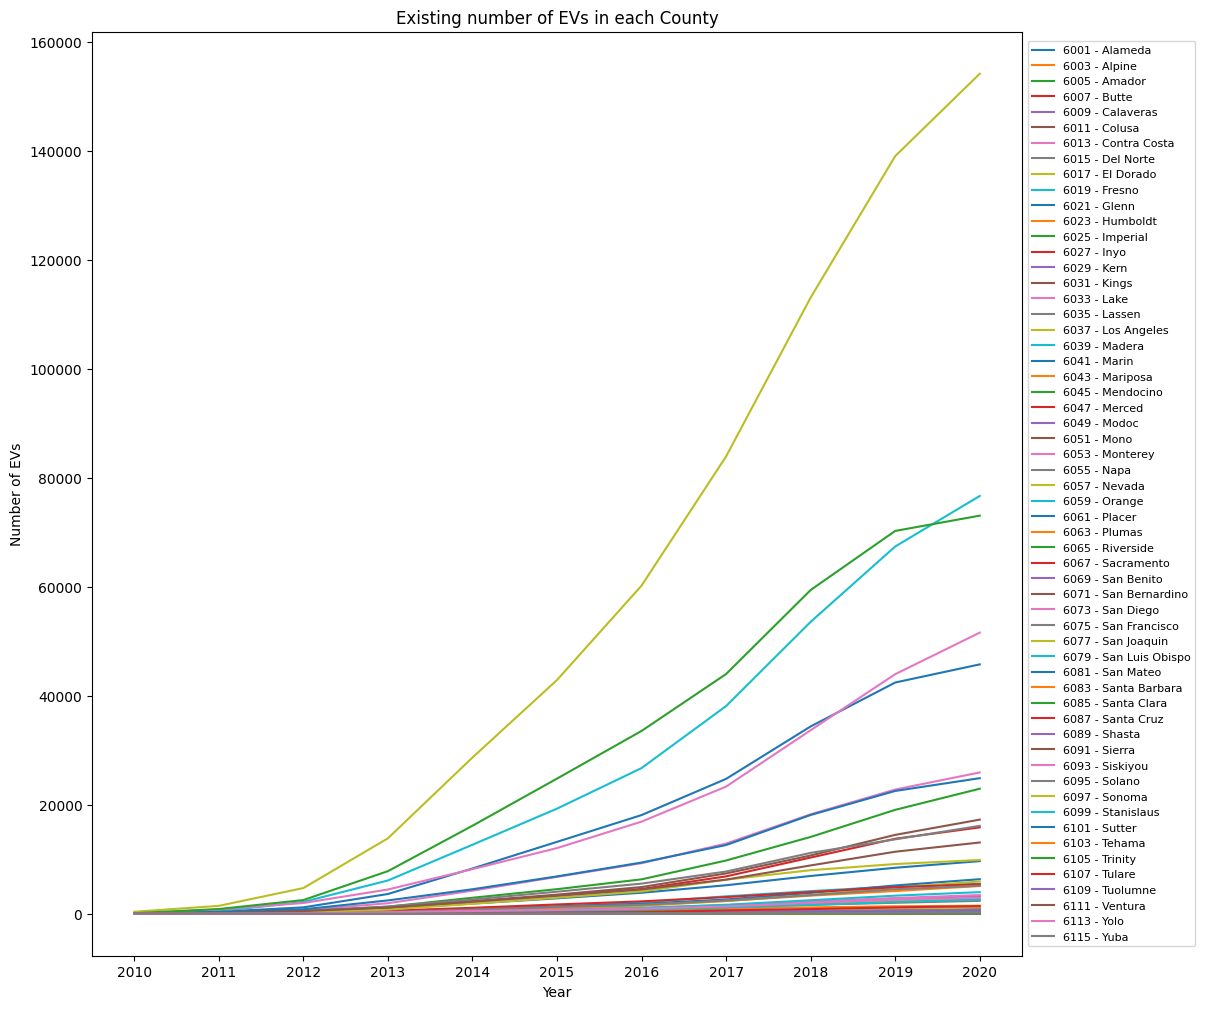

In [18]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named finalMergedData

# Convert numerical values to strings for concatenation
finalMergedData['County GEOID'] = finalMergedData['County GEOID'].astype(str)

# Combine "County GEOID" and "NAME" columns as the label for each line
finalMergedData['Label'] = finalMergedData['County GEOID'] + ' - ' + finalMergedData['NAME']

# Get the columns '2010' to '2020' as the X labels
x_labels = [str(year) for year in range(2010, 2021)]

# Set the figure size
plt.figure(figsize=(12, 12))

# Plotting the line chart
for _, row in finalMergedData.iterrows():
    data = row[finalMergedData.columns[1:12]]  # Slice the second to twelfth columns
    plt.plot(x_labels, data, label=row['Label'])

# Add labels and title to the chart
plt.xlabel('Year')
plt.ylabel('Number of EVs')
plt.title('Existing number of EVs in each County')

# Customize the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Existing number of EVs in each County.png', dpi=300, bbox_inches='tight')

# Show the line chart
plt.show()



In [19]:
chargerData

,County,Q2 2020-Public Level 1,Q2 2020-Shared Private Level 1,Q2 2020-Public Level 2,Q2 2020-Shared Private Level 2,Q2 2020-Public DC Fast,Q2 2020-Shared Private DC Fast,Q2 2020-Total,Q3 2020-Public Level 1,Q3 2020-Shared Private Level 1,Q3 2020-Public Level 2,Q3 2020-Shared Private Level 2,Q3 2020-Public DC Fast,Q3 2020-Shared Private DC Fast,Q3 2020-Total,Q4 2020-Public Level 1,Q4 2020-Shared Private Level 1,Q4 2020-Public Level 2,Q4 2020-Shared Private Level 2,Q4 2020-Public DC Fast,Q4 2020-Shared Private DC Fast,Q4 2020-Total,Q1 2021-Public Level 1,Q1 2021-Shared Private Level 1,Q1 2021-Public Level 2,Q1 2021-Shared Private Level 2,Q1 2021-Public DC Fast,Q1 2021-Shared Private DC Fast,Q1 2021-Total,Q2 2021-Public Level 1,Q2 2021-Shared Private Level 1,Q2 2021-Public Level 2,Q2 2021-Shared Private Level 2,Q2 2021-Public DC Fast,Q2 2021-Shared Private DC Fast,Q2 2021-Total,Q3 2021-Public Level 1,Q3 2021-Shared Private Level 1,Q3 2021-Public Level 2,Q3 2021-Shared Private Level 2,Q3 2021-Public DC Fast,Q3 2021-Shared Private DC Fast,Q3 2021-Total,Q4 2021-Public Level 1,Q4 2021-Shared Private Level 1,Q4 2021-Public Level 2,Q4 2021-Shared Private Level 2,Q4 2021-Public DC Fast,Q4 2021-Shared Private DC Fast,Q4 2021-Total,Q1 2022-Public Level 1,Q1 2022-Shared Private Level 1,Q1 2022-Public Level 2,Q1 2022-Shared Private Level 2,Q1 2022-Public DC Fast,Q1 2022-Shared Private DC Fast,Q1 2022-Total,Q2 2022-Public Level 1,Q2 2022-Shared Private Level 1,Q2 2022-Public Level 2,Q2 2022-Shared Private Level 2,Q2 2022-Public DC Fast,Q2 2022-Shared Private DC Fast,Q2 2022-Total,Q3 2022-Public Level 1,Q3 2022-Shared Private Level 1,Q3 2022-Public Level 2,Q3 2022-Shared Private Level 2,Q3 2022-Public DC Fast,Q3 2022-Shared Private DC Fast,Q3 2022-Total,Q4 2022-Public Level 1,Q4 2022-Shared Private Level 1,Q4 2022-Public Level 2,Q4 2022-Shared Private Level 2,Q4 2022-Public DC Fast,Q4 2022-Shared Private DC Fast,Q4 2022-Total
0,Alameda,14,14,1274,1398,258,32,2990,14,14,1288,1460,268,38,3082,14,14,1519,1472,296,38,3353,14,63,1635,1497,292,43,3544,14,63,1633,1497,310,43,3560,14,66,1633,1554,315,43,3625,6,70,1671,1583,332,35,3697,0,70,1671,2080,347,34,5051,0,70,1724,2104,366,34,5139,0,70,1465,2334,375,38,4282,4,66,1473,2465,385,37,4430
1,Alpine,0,0,12,0,0,0,12,0,0,12,1,0,0,13,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,0,0,0,14,0,0,18,0,0,0,18,0,0,16,0,0,0,16,0,0,16,0,0,0,16,0,0,6,0,0,0,6
2,Amador,0,0,23,6,0,0,29,0,0,23,7,0,0,30,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,6,8,0,39,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,26,0,8,0,34
3,Butte,6,0,32,20,16,0,74,6,0,32,20,16,2,76,6,0,30,22,16,2,76,6,0,36,22,16,2,82,6,0,44,22,17,2,91,6,0,41,22,21,2,92,6,0,41,23,24,0,94,6,0,41,45,27,1,132,6,0,66,46,27,1,158,6,0,59,46,27,1,139,6,0,59,55,26,0,146
4,Calaveras,0,0,7,0,0,0,7,0,0,7,0,0,0,7,0,0,7,0,0,0,7,0,0,7,0,12,0,19,0,0,7,0,12,0,19,0,2,7,0,12,0,21,0,2,7,0,12,0,21,0,2,7,0,12,0,21,0,2,9,0,12,0,23,0,2,9,0,12,0,23,0,2,11,0,12,0,25
5,Colusa,0,0,16,2,10,0,28,0,0,16,2,10,0,28,0,0,16,2,10,0,28,0,0,16,2,10,0,28,0,0,18,2,10,0,30,0,0,18,2,14,0,34,0,0,18,2,18,0,38,0,0,18,0,18,0,36,0,0,18,0,18,0,36,0,0,16,0,18,0,34,0,0,14,2,18,0,34
6,Contra Costa,8,0,469,422,167,2,1068,8,0,490,656,164,7,1325,8,0,514,658,168,7,1355,7,2,574,660,205,7,1455,7,2,582,660,203,7,1461,7,2,599,660,208,7,1483,3,2,600,599,245,2,1451,2,2,589,442,252,1,1715,2,2,575,445,245,1,1699,0,2,630,608,251,4,1495,0,2,633,606,254,8,1503
7,Del Norte,0,0,10,0,20,0,30,0,0,10,0,20,0,30,0,0,10,0,20,0,30,0,0,10,0,15,0,25,0,0,10,0,15,0,25,0,0,12,0,17,0,29,0,0,12,0,17,0,29,0,0,12,1,17,2,32,0,0,12,1,17,2,32,0,0,14,1,22,2,39,0,0,14,1,22,2,39
8,El Dorado,1,0,109,5,35,0,150,1,0,117,6,35,1,160,1,0,122,6,43,1,173,1,0,122,6,37,1,167,1,0,124,6,45,1,177,1,0,124,6,49,1,181,1,0,124,5,49,0,179,1,0,124,0,48,0,173,1,0,144,0,48,0,193,1,0,140,4,48,1,194,1,0,138,4,45,1,189
9,Fresno,8,0,355,238,77,6,684,8,0,343,333,81,14,779,8,0,391,333,175,14,921,8,1,541,346,183,13,1092

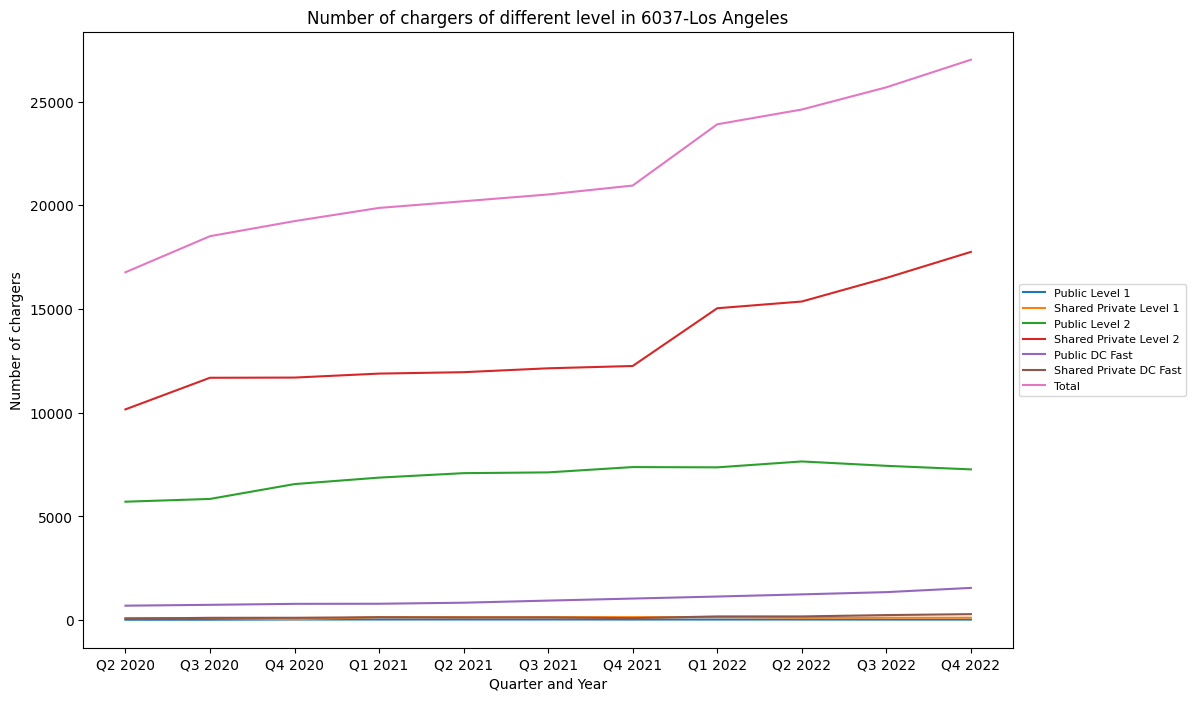

In [20]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named chargerData

# Select the desired row (e.g., row 18)
selected_row = chargerData.iloc[18]

# Define the desired x-axis labels
x_labels = [
    'Q2 2020', 'Q3 2020', 'Q4 2020', 'Q1 2021', 'Q2 2021', 'Q3 2021',
    'Q4 2021', 'Q1 2022', 'Q2 2022', 'Q3 2022', 'Q4 2022'
]

# Define the categories (levels)
categories = [
    'Public Level 1', 'Shared Private Level 1', 'Public Level 2',
    'Shared Private Level 2', 'Public DC Fast', 'Shared Private DC Fast',
    'Total'
]

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting the line chart for different categories (levels)
for category in categories:
    category_label = f"{category}"
    data_columns = [f"{label}-{category}" for label in x_labels]
    data = selected_row[data_columns]
    plt.plot(x_labels, data, label=category_label)

# Add labels and title to the chart
plt.xlabel('Quarter and Year')
plt.ylabel('Number of chargers')
plt.title('Number of chargers of different level in 6037-Los Angeles')

# Customize the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

# Disable scientific notation on the y-axis
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Number of chargers of different level in 6037-Los Angeles', dpi=300, bbox_inches='tight')

# Show the line chart
plt.show()


In [21]:
# Save DataFrame to CSV
finalMergedData.to_csv('finalMergedData.csv', index=True)

# ***EVs prediction***
## ***(Take Los Angeles as an example)***

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# List of years to consider for the lags
years = [str(year) for year in range(2010, 2021)]
# # Convert column names to strings using astype()
finalMergedData.columns = finalMergedData.columns.astype(str)
# Use the name of county
county_name = 'Los Angeles'
county_index = 18
# Extract the specific row for the county
county_data = finalMergedData.loc[finalMergedData['County'] == county_name, years]

In [23]:
county_data

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
18,360.0,1445.0,4716.0,13852.0,28680.0,42917.0,60248.0,83975.0,113139.0,139111.0,154234.0


In [24]:
neighbors = W.neighbors[county_index]

In [25]:
index_to_name = {i: name for i, name in enumerate(finalMergedData['County'])}
neighbor_names = [index_to_name[i] for i in neighbors]

In [26]:
neighbor_names

['Orange', 'Ventura']

In [27]:
spatial_feature = np.mean([finalMergedData.loc[finalMergedData['County'] == neighbor, years].values 
                           for neighbor in neighbor_names], axis=0)

In [28]:
spatial_feature

array([[4.00000e+01, 2.98500e+02, 1.32900e+03, 3.62300e+03, 7.45550e+03,
        1.12990e+04, 1.55955e+04, 2.21985e+04, 3.12330e+04, 3.94060e+04,
        4.48930e+04]])

In [29]:
lag_years = 3

# Convert the county_data and spatial_feature to lists
county_data_list = list(county_data.values.flatten())
spatial_feature_list = list(spatial_feature.flatten())

# Create lagged lists
lagged_data = {'Year': years[lag_years:]}
for i in range(lag_years, 0, -1):
    lagged_data[f'EV count (t-{i})'] = county_data_list[lag_years-i:-i or None]
    lagged_data[f'Avg. neighboring EV count (t-{i})'] = spatial_feature_list[lag_years-i:-i or None]
lagged_data['EV count (t)'] = county_data_list[lag_years:]

df = pd.DataFrame(lagged_data)

In [30]:
df

,Year,EV count (t-3),Avg. neighboring EV count (t-3),EV count (t-2),Avg. neighboring EV count (t-2),EV count (t-1),Avg. neighboring EV count (t-1),EV count (t)
0,2013,360.0,40.0,1445.0,298.5,4716.0,1329.0,13852.0
1,2014,1445.0,298.5,4716.0,1329.0,13852.0,3623.0,28680.0
2,2015,4716.0,1329.0,13852.0,3623.0,28680.0,7455.5,42917.0
3,2016,13852.0,3623.0,28680.0,7455.5,42917.0,11299.0,60248.0
4,2017,28680.0,7455.5,42917.0,11299.0,60248.0,15595.5,83975.0
5,2018,42917.0,11299.0,60248.0,15595.5,83975.0,22198.5,113139.0
6,2019,60248.0,15595.5,83975.0,22198.5,113139.0,31233.0,139111.0
7,2020,83975.0,22198.5,113139.0,31233.0,139111.0,39406.0,154234.0


In [31]:
# Select features and target
X = df[['EV count (t-3)', 'EV count (t-2)', 'EV count (t-1)', 
        'Avg. neighboring EV count (t-3)', 'Avg. neighboring EV count (t-2)', 
        'Avg. neighboring EV count (t-1)']].values
y = df['EV count (t)'].values

# Select training and testing data
X_train, y_train = X[:-2], y[:-2]  # all but the last two data points
X_test, y_test = X[-2:], y[-2:]  # only the last two data points

In [32]:
X_train, y_train, X_test, y_test

(array([[3.60000e+02, 1.44500e+03, 4.71600e+03, 4.00000e+01, 2.98500e+02,
         1.32900e+03],
        [1.44500e+03, 4.71600e+03, 1.38520e+04, 2.98500e+02, 1.32900e+03,
         3.62300e+03],
        [4.71600e+03, 1.38520e+04, 2.86800e+04, 1.32900e+03, 3.62300e+03,
         7.45550e+03],
        [1.38520e+04, 2.86800e+04, 4.29170e+04, 3.62300e+03, 7.45550e+03,
         1.12990e+04],
        [2.86800e+04, 4.29170e+04, 6.02480e+04, 7.45550e+03, 1.12990e+04,
         1.55955e+04],
        [4.29170e+04, 6.02480e+04, 8.39750e+04, 1.12990e+04, 1.55955e+04,
         2.21985e+04]]),
 array([ 13852.,  28680.,  42917.,  60248.,  83975., 113139.]),
 array([[ 60248. ,  83975. , 113139. ,  15595.5,  22198.5,  31233. ],
        [ 83975. , 113139. , 139111. ,  22198.5,  31233. ,  39406. ]]),
 array([139111., 154234.]))

In [33]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
# Define the kernel
kernel = DotProduct() + WhiteKernel()

# Fit the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(X_train, y_train)

C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [34]:
# Predict the test set results
y_pred, sigma_test = gpr.predict(X_test, return_std=True)

# Calculate the mean squared error of the predictions
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the mean absolute error of the predictions
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the r2 score of the predictions
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

# Let's print the actual and predicted values side by side
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison)


Mean Squared Error: 461535313.53023124
Mean Absolute Error: 19595.709047527984
R^2 Score: -7.072146270584621
     Actual      Predicted
0  139111.0  149900.830303
1  154234.0  182635.587792


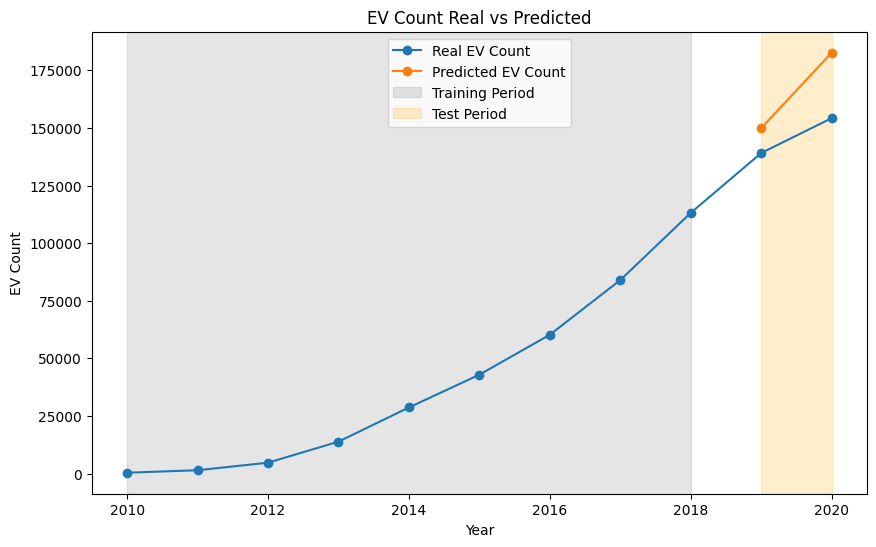

In [35]:
import matplotlib.pyplot as plt

# Define the years
years = list(range(2010, 2021))

# Define the real EV count
real_count = list(county_data.values.flatten())

# Create a new list that is empty for the years you didn't predict
predicted_count = [None]*9 + list(y_pred)

# Create the plot
plt.figure(figsize=(10,6))

# Plot the real data
plt.plot(years, real_count, label='Real EV Count', marker='o')

# Plot the predicted data
plt.plot(years, predicted_count, label='Predicted EV Count', marker='o')

# Highlight the training and testing periods
plt.axvspan(2010, 2018, color='gray', alpha=0.2, label='Training Period')
plt.axvspan(2019, 2020, color='orange', alpha=0.2, label='Test Period')

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Year')
plt.ylabel('EV Count')
plt.title('EV Count Real vs Predicted')

# Show the plot
plt.show()


In [36]:
# Recalculate predictions for test years with standard deviations
y_pred_test, sigma_test = gpr.predict(X_test, return_std=True)

# Define the feature vector for 2021
X_2021 = np.array([[county_data['2018'].values[0], 
                    county_data['2019'].values[0], 
                    county_data['2020'].values[0], 
                    spatial_feature[0][-3], 
                    spatial_feature[0][-2], 
                    spatial_feature[0][-1]]])

# Predict for 2021
y_pred_2021, sigma_2021 = gpr.predict(X_2021, return_std=True)

# Flatten the y_pred_2021 array to a 1D array
y_pred_2021_flat = y_pred_2021.flatten()

# Concatenate the predictions
y_pred = np.concatenate((y_pred_test, y_pred_2021_flat))

# Flatten the sigma_2021 array to a 1D array
sigma_2021_flat = sigma_2021.flatten()

# Concatenate the standard deviations
sigma = np.concatenate((sigma_test, sigma_2021_flat))


years_extended = np.append(years, ['2021'])



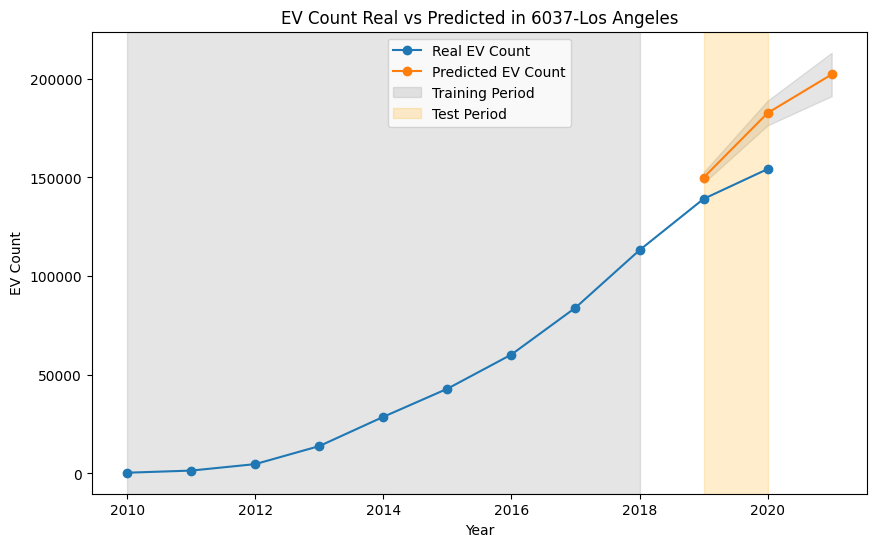

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Define the years
years = list(range(2010, 2022))  # Extend to 2022 for including the prediction for 2021

# Define the real EV count
real_count = list(county_data.values.flatten())

# Create a new list that includes the predictions for 2019, 2020, and 2021
predicted_count = [None]*9 + list(y_pred) #+ [y_pred_2021.item()]  # Use .item() to get the value from the 1-element array

# Also define the confidence intervals
ci_upper = [None]*9 + list(y_pred + 1.96*sigma)
ci_lower = [None]*9 + list(y_pred - 1.96*sigma)

# Define the years where predictions were made
pred_years = years[-len(sigma):]  # Only take the years where predictions exist

# Create the plot
plt.figure(figsize=(10,6))

# Plot the real data
plt.plot(years[:-1], real_count, label='Real EV Count', marker='o')

# Plot the predicted data
plt.plot(years, predicted_count, label='Predicted EV Count', marker='o')

# Plot the confidence intervals for the predicted years
plt.fill_between(pred_years, ci_lower[-len(sigma):], ci_upper[-len(sigma):], color='gray', alpha=0.2)

# Highlight the training and testing periods
plt.axvspan(2010, 2018, color='gray', alpha=0.2, label='Training Period')
plt.axvspan(2019, 2020, color='orange', alpha=0.2, label='Test Period')

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Year')
plt.ylabel('EV Count')
plt.title('EV Count Real vs Predicted in 6037-Los Angeles')

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('EV Count Real vs Predicted in 6037-Los Angeles', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# ***Consider population and income***

In [38]:
import pandas as pd

# Load the two sheets into two dataframes
df_population = pd.read_excel('Total_Population.xlsx', sheet_name='POPULATION')
df_economic = pd.read_excel('Total_Population.xlsx', sheet_name='ECONOMIC-PER PEOPLE')

# Merge the two dataframes on the 'County' column
df_extra = pd.merge(df_population, df_economic, on='County')

In [39]:
# Extract the data from the 11th row to a new array
# (remember that Python uses 0-based indexing, so the 11th row would have index 10)
PopulationIncomeData = df_extra.iloc[10, 1:].values

In [40]:
PopulationIncomeData.shape

(24,)

In [41]:
# Define the years
years = np.array(list(range(2010, 2022)) * 2)

# Split the data into two arrays
population_data = PopulationIncomeData[:11]
income_data = PopulationIncomeData[12:23]

# Reshape the arrays
population = np.column_stack((population_data))
income = np.column_stack((income_data))

In [42]:
income

array([[27344., 26349., 26467., 27488., 28373., 29403., 30824., 32413.,
        34115., 36044., 37216.]])

In [43]:
# Convert the population and income to lists
population_list = list(population.flatten())
income_list = list(income.flatten())

# Create lagged lists for population and income
for i in range(lag_years, 0, -1):
    lagged_data[f'Population (t-{i})'] = population_list[lag_years-i:-i or None]
    lagged_data[f'Income (t-{i})'] = income_list[lag_years-i:-i or None]

# Add the population and income at time t to the dataframe
lagged_data['Population (t)'] = population_list[lag_years:]
lagged_data['Income (t)'] = income_list[lag_years:]

# Create a dataframe from the lagged data
df = pd.DataFrame(lagged_data)


In [44]:
df

,Year,EV count (t-3),Avg. neighboring EV count (t-3),EV count (t-2),Avg. neighboring EV count (t-2),EV count (t-1),Avg. neighboring EV count (t-1),EV count (t),Population (t-3),Income (t-3),Population (t-2),Income (t-2),Population (t-1),Income (t-1),Population (t),Income (t)
0,2013,360.0,40.0,1445.0,298.5,4716.0,1329.0,13852.0,9830420.0,27344.0,9889056.0,26349.0,9962789.0,26467.0,10017068.0,27488.0
1,2014,1445.0,298.5,4716.0,1329.0,13852.0,3623.0,28680.0,9889056.0,26349.0,9962789.0,26467.0,10017068.0,27488.0,10116705.0,28373.0
2,2015,4716.0,1329.0,13852.0,3623.0,28680.0,7455.5,42917.0,9962789.0,26467.0,10017068.0,27488.0,10116705.0,28373.0,10170292.0,29403.0
3,2016,13852.0,3623.0,28680.0,7455.5,42917.0,11299.0,60248.0,10017068.0,27488.0,10116705.0,28373.0,10170292.0,29403.0,10137915.0,30824.0
4,2017,28680.0,7455.5,42917.0,11299.0,60248.0,15595.5,83975.0,10116705.0,28373.0,10170292.0,29403.0,10137915.0,30824.0,10163507.0,32413.0
5,2018,42917.0,11299.0,60248.0,15595.5,83975.0,22198.5,113139.0,10170292.0,29403.0,10137915.0,30824.0,10163507.0,32413.0,10105518.0,34115.0
6,2019,60248.0,15595.5,83975.0,22198.5,113139.0,31233.0,139111.0,10137915.0,30824.0,10163507.0,32413.0,10105518.0,34115.0,10039107.0,36044.0
7,2020,83975.0,22198.5,113139.0,31233.0,139111.0,39406.0,154234.0,10163507.0,32413.0,10105518.0,34115.0,10039107.0,36044.0,9934325.5,37216.0


In [45]:
# Select features and target
X2 = df[['EV count (t-3)', 'EV count (t-2)', 'EV count (t-1)', 
        'Avg. neighboring EV count (t-3)', 'Avg. neighboring EV count (t-2)', 
        'Avg. neighboring EV count (t-1)','Population (t-3)','Population (t-2)','Population (t-1)','Income (t-3)','Income (t-2)','Income (t-2)']].values
y2 = df['EV count (t)'].values

# Select training and testing data
X2_train, y2_train = X2[:-2], y2[:-2]  # all but the last two data points
X2_test, y2_test = X2[-2:], y2[-2:]  # only the last two data points

In [46]:

# Fit the GPR model
gpr2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(X2_train, y2_train)
# Predict the test set results
y2_pred, sigma2_test = gpr2.predict(X2_test, return_std=True)

# Calculate the mean squared error of the predictions
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y2_test, y2_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the mean absolute error of the predictions
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y2_test, y2_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the r2 score of the predictions
from sklearn.metrics import r2_score
r2 = r2_score(y2_test, y2_pred)
print(f"R^2 Score: {r2}")

# Let's print the actual and predicted values side by side
comparison = pd.DataFrame({'Actual': y2_test, 'Predicted': y2_pred})
print(comparison)

Mean Squared Error: 514548601.882887
Mean Absolute Error: 21884.175369262695
R^2 Score: -7.999336466702275
     Actual      Predicted
0  139111.0  155025.965179
1  154234.0  182087.385559


C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [47]:
population, spatial_feature

(array([[ 9830420. ,  9889056. ,  9962789. , 10017068. , 10116705. ,
         10170292. , 10137915. , 10163507. , 10105518. , 10039107. ,
          9934325.5]]),
 array([[4.00000e+01, 2.98500e+02, 1.32900e+03, 3.62300e+03, 7.45550e+03,
         1.12990e+04, 1.55955e+04, 2.21985e+04, 3.12330e+04, 3.94060e+04,
         4.48930e+04]]))

In [48]:
# Define the feature vector for 2021
X2_2021 = np.array([[county_data['2018'].values[0], 
                    county_data['2019'].values[0], 
                    county_data['2020'].values[0], 
                    spatial_feature[0][-3], 
                    spatial_feature[0][-2], 
                    spatial_feature[0][-1],
                    population[0][-3],
                    population[0][-2],
                    population[0][-1],
                    income[0][-3],
                    income[0][-2],
                    income[0][-1]]])

# Predict for 2021
y_pred2_2021, sigma2_2021 = gpr2.predict(X2_2021, return_std=True)

# Flatten the y_pred_2021 array to a 1D array
y_pred2_2021_flat = y_pred2_2021.flatten()

# Concatenate the predictions
y_pred2 = np.concatenate((y2_pred, y_pred2_2021_flat))

# Flatten the sigma_2021 array to a 1D array
sigma2_2021_flat = sigma2_2021.flatten()

# Concatenate the standard deviations
sigma2 = np.concatenate((sigma2_test, sigma2_2021_flat))


years_extended = np.append(years, ['2021'])



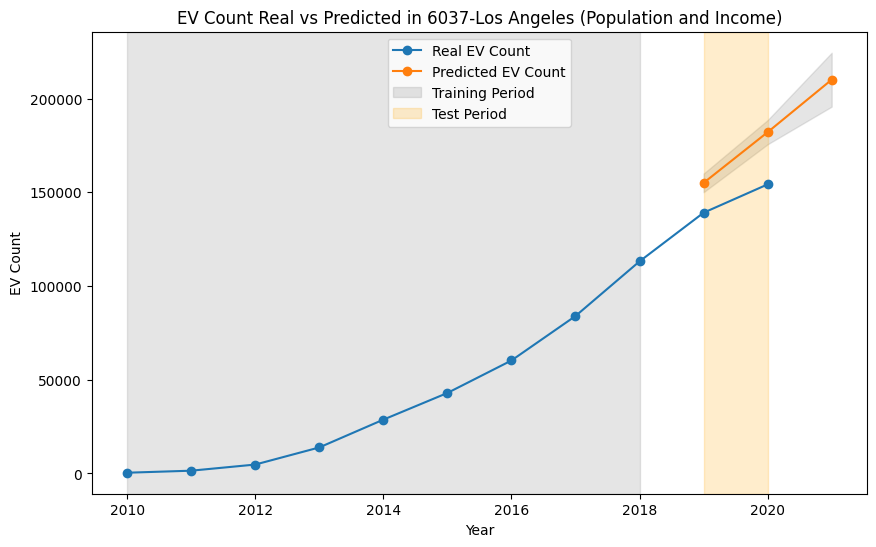

In [49]:



import matplotlib.pyplot as plt
import numpy as np

# Define the years
years = list(range(2010, 2022))  # Extend to 2022 for including the prediction for 2021

# Define the real EV count
real2_count = list(county_data.values.flatten())

# Create a new list that includes the predictions for 2019, 2020, and 2021
predicted2_count = [None]*9 + list(y_pred2) #+ [y_pred_2021.item()]  # Use .item() to get the value from the 1-element array

# Also define the confidence intervals
ci2_upper = [None]*9 + list(y_pred2 + 1.96*sigma2)
ci2_lower = [None]*9 + list(y_pred2 - 1.96*sigma2)

# Define the years where predictions were made
pred_years = years[-len(sigma):]  # Only take the years where predictions exist

# Create the plot
plt.figure(figsize=(10,6))

# Plot the real data
plt.plot(years[:-1], real2_count, label='Real EV Count', marker='o')

# Plot the predicted data
plt.plot(years, predicted2_count, label='Predicted EV Count', marker='o')

# Plot the confidence intervals for the predicted years
plt.fill_between(pred_years, ci2_lower[-len(sigma):], ci2_upper[-len(sigma):], color='gray', alpha=0.2)

# Highlight the training and testing periods
plt.axvspan(2010, 2018, color='gray', alpha=0.2, label='Training Period')
plt.axvspan(2019, 2020, color='orange', alpha=0.2, label='Test Period')

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('Year')
plt.ylabel('EV Count')
plt.title('EV Count Real vs Predicted in 6037-Los Angeles (Population and Income)')

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('EV Count Real vs Predicted in 6037-Los Angeles (Population and Income)', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# ***Auto-Arima model***

In [50]:
county_data.shape

(1, 11)

In [51]:
county_data

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
18,360.0,1445.0,4716.0,13852.0,28680.0,42917.0,60248.0,83975.0,113139.0,139111.0,154234.0


In [52]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np
# Convert pandas DataFrame to numpy array and flatten it
county_data_np = county_data.values.flatten()

# Check the length of county_data_np
print(len(county_data_np))

# Calculate size for training set: 80% of the entire data
train_size = int(len(county_data_np) * 0.8)

print(train_size)
train, test = county_data_np[:train_size], county_data_np[train_size:]
model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)


11
8
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.712, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=182.224, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=196.593, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=172.376, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.395 seconds


ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [53]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert pandas DataFrame to numpy array and flatten it
county_data_np = county_data.values.flatten()

# Split the data into training and test sets
train_size = int(len(county_data_np) * 0.8)
train, test = county_data_np[:train_size], county_data_np[train_size:]

# Fit the Auto-ARIMA model on training data
model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

# Use the model to forecast the test data
forecast = model.predict(n_periods=len(test))

# Print the root mean squared error (RMSE)
mse = mean_squared_error(test, forecast)
print('Test RMSE: ', np.sqrt(mse))

# Now, fit the model on the entire data for future forecasting
model = auto_arima(county_data_np, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(county_data_np)

# Forecast the number of EVs for future years
future_forecast, conf_int = model.predict(n_periods=3, return_conf_int=True)
print('Forecast for 2021, 2022, 2023: ', future_forecast)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.712, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=182.224, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=196.593, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=172.376, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.458 seconds
Test RMSE:  13980.05685532097
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.451, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=253.946, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=280.561, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=233.706, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=i

In [54]:
forecast, future_forecast 

(array([104911.20944761, 122982.20786631, 138156.32927417]),
 array([160386.62055999, 159256.38850938, 151340.00322122]))

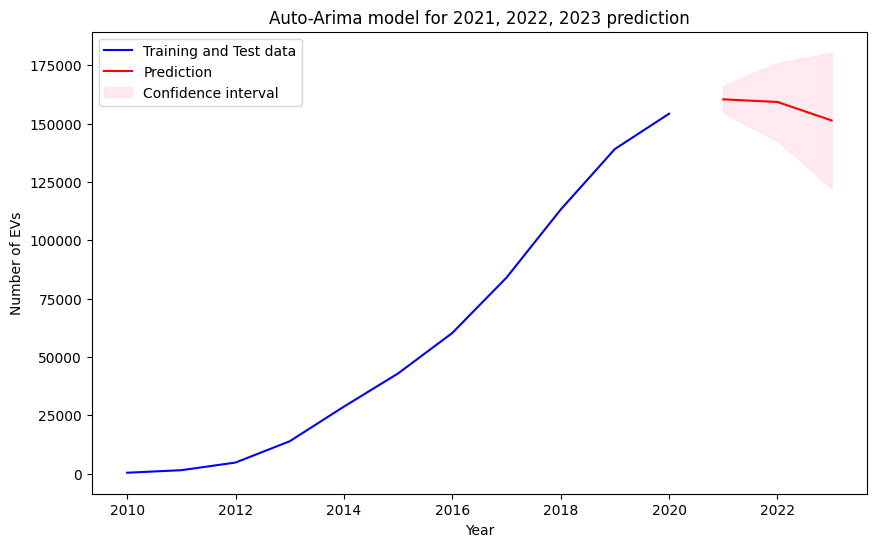

In [55]:
import matplotlib.pyplot as plt

# Generate the years
years = list(range(2010, 2024))

# Define the years for training, testing, and prediction
train_years = years[:train_size]
test_years = years[train_size:train_size+len(test)]
pred_years = years[train_size+len(test):]

# Define the corresponding data for training, testing, and prediction
train_data = county_data_np[:train_size]
test_data = county_data_np[train_size:train_size+len(test)]
#pred_test_data = forecast[-3:]
pred_data = future_forecast[-3:]


# Define the confidence intervals for the prediction
conf_int = conf_int[-3:]

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the training data and test data
plt.plot(np.concatenate((train_years, test_years)), np.concatenate((train_data, test_data)), label='Training and Test data', color='blue')

# Plot the prediction
plt.plot(pred_years, future_forecast, label='Prediction', color='red')

# Plot the confidence intervals
plt.fill_between(pred_years, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=.3, label='Confidence interval')

# Set the x and y labels
plt.xlabel('Year')
plt.ylabel('Number of EVs')

# Add a legend
plt.legend()

plt.title('Auto-Arima model for 2021, 2022, 2023 prediction')

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Auto-Arima model for 2021, 2022, 2023 prediction', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


# ***Top tpyes of EVs***

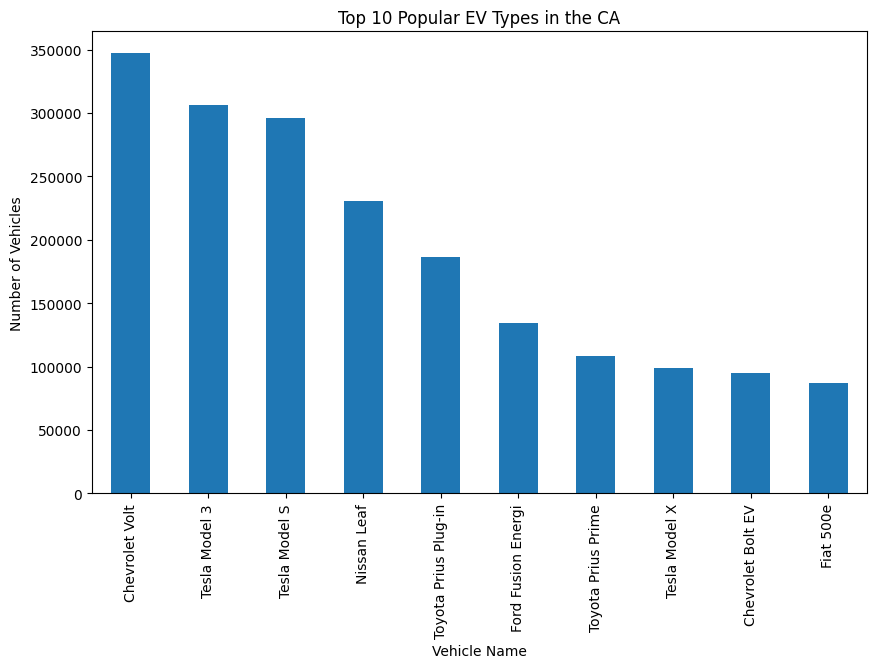

In [56]:
# Count the unique values in the 'Vehicle Name' column and take the first 10
top_10_EV_types_total = regData['Vehicle Name'].value_counts().head(10)

# Plot the top 10 popular EV types
top_10_EV_types_total.plot(kind='bar', figsize=(10,6))
plt.title('Top 10 Popular EV Types in the CA')
plt.xlabel('Vehicle Name')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=90) 
# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Top 10 Popular EV Types in the CA', dpi=300, bbox_inches='tight')
plt.show()


In [57]:
# 1. Count different Vehicle Name in each County GEOID.
vehicle_count = regData.groupby('County GEOID')['Vehicle Name'].nunique()

In [58]:
# 2. Find the Name of each county corresponding to the County GEOID.
# Merge the two dataframes on the GEOID column
merged_df = pd.merge(regData, S[['GEOID', 'NAME']], left_on='County GEOID', right_on='GEOID', how='left')
# Now each row in merged_df has an associated county name.


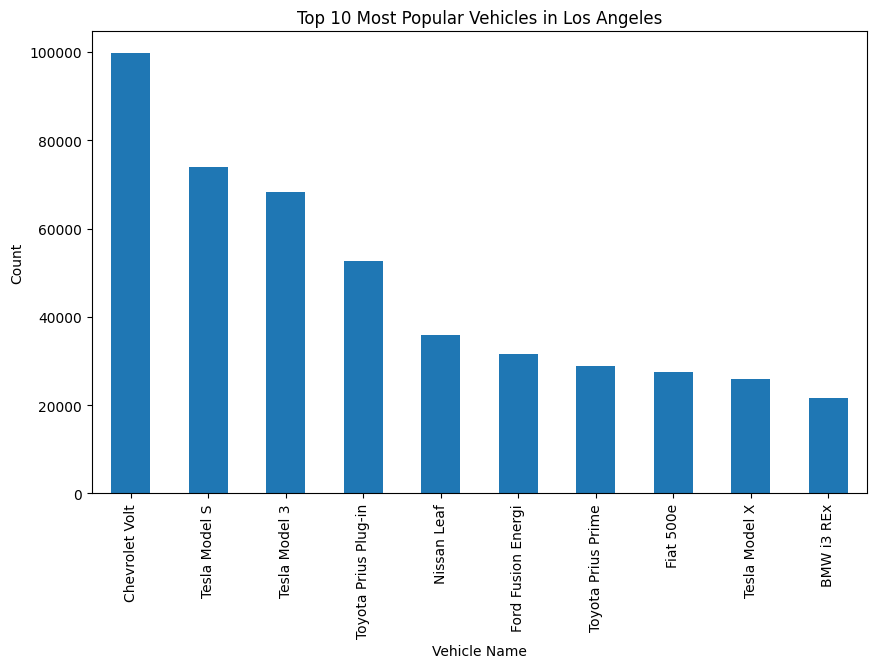

In [59]:
# 3. Plot the top 10 most popular Vehicle Name in Los Angeles in histogram.
# Filter the data for Los Angeles
la_data = merged_df[merged_df['NAME'] == 'Los Angeles']

# Count the occurrences of each vehicle name
la_vehicle_counts = la_data['Vehicle Name'].value_counts()

# Get the top 10 vehicles
top_10_vehicles = la_vehicle_counts.head(10)

# Plot the histogram
top_10_vehicles.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Vehicle Name')
plt.ylabel('Count')
plt.title('Top 10 Most Popular Vehicles in Los Angeles')
# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Top 10 Most Popular Vehicles in Los Angeles', dpi=300, bbox_inches='tight')

plt.show()


# ***Focus on the top 10 counties have greatest number of EVs***

In [60]:
finalMergedData

,County GEOID,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Total,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Centroid_X,Centroid_Y,County,Q2 2020-Public Level 1,Q2 2020-Shared Private Level 1,Q2 2020-Public Level 2,Q2 2020-Shared Private Level 2,Q2 2020-Public DC Fast,Q2 2020-Shared Private DC Fast,Q2 2020-Total,Q3 2020-Public Level 1,Q3 2020-Shared Private Level 1,Q3 2020-Public Level 2,Q3 2020-Shared Private Level 2,Q3 2020-Public DC Fast,Q3 2020-Shared Private DC Fast,Q3 2020-Total,Q4 2020-Public Level 1,Q4 2020-Shared Private Level 1,Q4 2020-Public Level 2,Q4 2020-Shared Private Level 2,Q4 2020-Public DC Fast,Q4 2020-Shared Private DC Fast,Q4 2020-Total,Q1 2021-Public Level 1,Q1 2021-Shared Private Level 1,Q1 2021-Public Level 2,Q1 2021-Shared Private Level 2,Q1 2021-Public DC Fast,Q1 2021-Shared Private DC Fast,Q1 2021-Total,Q2 2021-Public Level 1,Q2 2021-Shared Private Level 1,Q2 2021-Public Level 2,Q2 2021-Shared Private Level 2,Q2 2021-Public DC Fast,Q2 2021-Shared Private DC Fast,Q2 2021-Total,Q3 2021-Public Level 1,Q3 2021-Shared Private Level 1,Q3 2021-Public Level 2,Q3 2021-Shared Private Level 2,Q3 2021-Public DC Fast,Q3 2021-Shared Private DC Fast,Q3 2021-Total,Q4 2021-Public Level 1,Q4 2021-Shared Private Level 1,Q4 2021-Public Level 2,Q4 2021-Shared Private Level 2,Q4 2021-Public DC Fast,Q4 2021-Shared Private DC Fast,Q4 2021-Total,Q1 2022-Public Level 1,Q1 2022-Shared Private Level 1,Q1 2022-Public Level 2,Q1 2022-Shared Private Level 2,Q1 2022-Public DC Fast,Q1 2022-Shared Private DC Fast,Q1 2022-Total,Q2 2022-Public Level 1,Q2 2022-Shared Private Level 1,Q2 2022-Public Level 2,Q2 2022-Shared Private Level 2,Q2 2022-Public DC Fast,Q2 2022-Shared Private DC Fast,Q2 2022-Total,Q3 2022-Public Level 1,Q3 2022-Shared Private Level 1,Q3 2022-Public Level 2,Q3 2022-Shared Private Level 2,Q3 2022-Public DC Fast,Q3 2022-Shared Private DC Fast,Q3 2022-Total,Q4 2022-Public Level 1,Q4 2022-Shared Private Level 1,Q4 2022-Public Level 2,Q4 2022-Shared Private Level 2,Q4 2022-Public DC Fast,Q4 2022-Shared Private DC Fast,Q4 2022-Total,Label
0,6001,20.0,362.0,1168.0,3622.0,8304.0,13197.0,18116.0,24758.0,34389.0,42451.0,45785.0,192172.0,06,001,01675839,6001,Alameda,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,+37.6471385,-121.9124880,"POLYGON ((-13612246.763 4538150.085, -13612346...",-1.357185e+07,4.530207e+06,Alameda,14,14,1274,1398,258,32,2990,14,14,1288,1460,268,38,3082,14,14,1519,1472,296,38,3353,14,63,1635,1497,292,43,3544,14,63,1633,1497,310,43,3560,14,66,1633,1554,315,43,3625,6,70,1671,1583,332,35,3697,0,70,1671,2080,347,34,5051,0,70,1724,2104,366,34,5139,0,70,1465,2334,375,38,4282,4,66,1473,2465,385,37,4430,6001 - Alameda
1,6003,0.0,0.0,0.0,2.0,5.0,3.0,4.0,3.0,4.0,6.0,11.0,38.0,06,003,01675840,6003,Alpine,Alpine County,06,H1,G4020,NaN,NaN,NaN,A,1912292633,12557304,+38.6217831,-119.7983522,"POLYGON ((-13366503.508 4678946.015, -13366492...",-1.333838e+07,4.664193e+06,Alpine,0,0,12,0,0,0,12,0,0,12,1,0,0,13,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,0,0,0,14,0,0,18,0,0,0,18,0,0,16,0,0,0,16,0,0,16,0,0,0,16,0,0,6,0,0,0,6,6003 - Alpine
2,6005,1.0,6.0,8.0,9.0,21.0,44.0,58.0,92.0,128.0,175.0,226.0,768.0,06,005,01675841,6005,Amador,Amador County,06,H1,G4020,NaN,NaN,NaN,A,1539933576,29470568,+38.4435501,-120.6538563,"POLYGON ((-13472697.863 4647652.232, -13472697...",-1.343079e+07,4.642708e+06,Amador,0,0,23,6,0,0,29,0,0,23,7,0,0,30,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,6,8,0,39,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,26,0,8,0,34,6005 - Amador
3,6007,0.0,8.0,28.0,69.0,134.0,178.0,245.0,395.0,588.0,796.0,982.0,3423.0,06,007,01675842,6007,Butte,Butte County,06,H1,G4020,NaN,17020,NaN,A,4238423343,105325812,+39.6659588,-121.6019188,"POLYGON ((-13565004.793 4798394.124, -13564991...",-1.353652e+07,4.817778e+06,Butte,6,0,32,20,16,0,74,6,0,32

In [61]:
# Assuming your DataFrame is named 'finalMergedData'

# Select the top 10 counties with the greatest values in the 'Total' column
top_10_counties = finalMergedData.nlargest(10, 'Total')

# Retrieve county names and row indices
top_10_county_names = top_10_counties['NAME']
top_10_county_index = top_10_counties.index


In [62]:
top_10_county_names, top_10_county_index

(18       Los Angeles
 42       Santa Clara
 29            Orange
 36         San Diego
 0            Alameda
 6       Contra Costa
 40         San Mateo
 32         Riverside
 37     San Francisco
 35    San Bernardino
 Name: NAME, dtype: object,
 Index([18, 42, 29, 36, 0, 6, 40, 32, 37, 35], dtype='int64'))

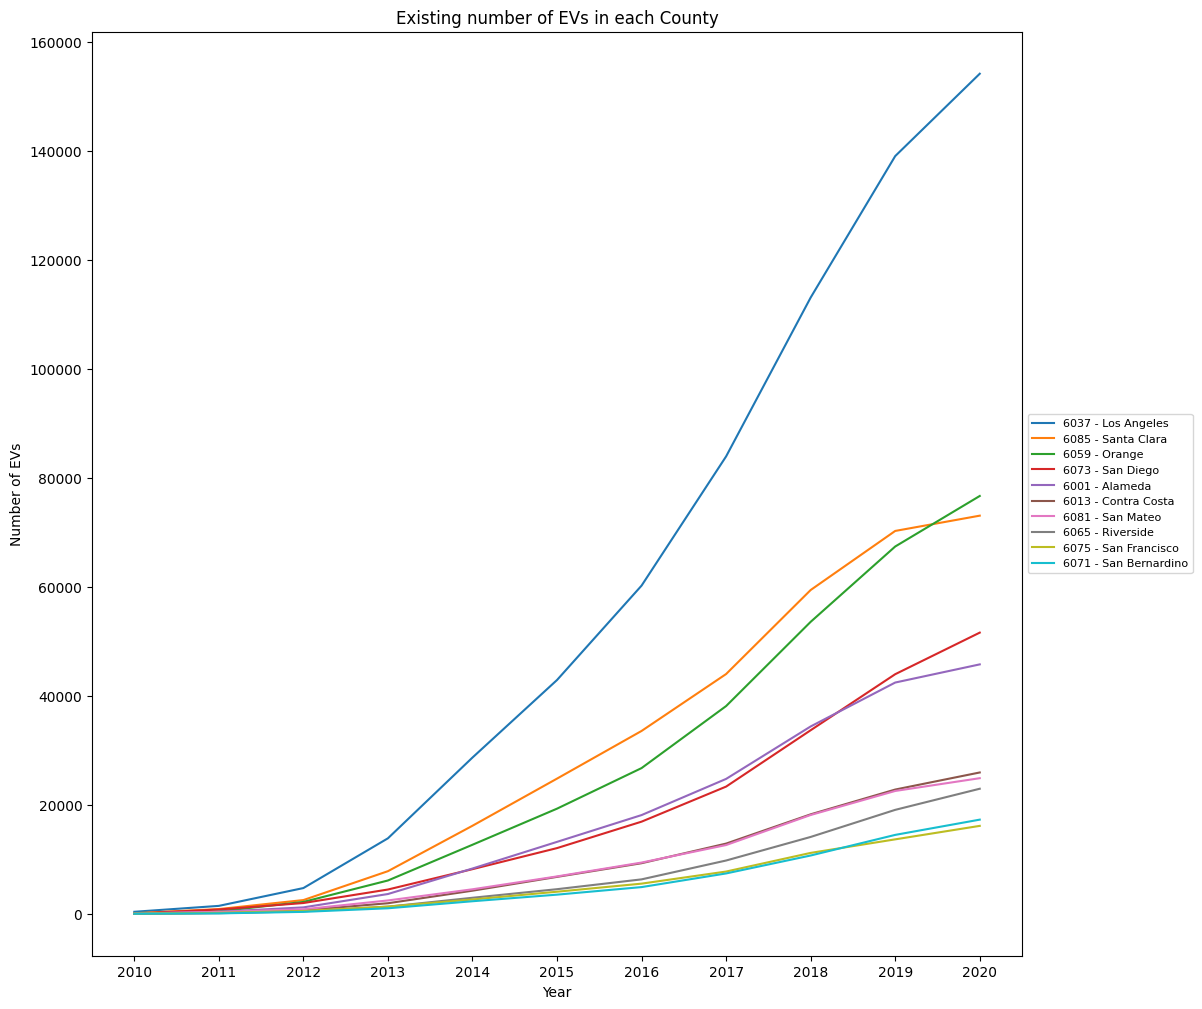

In [63]:
# Set the figure size
plt.figure(figsize=(12, 12))

x_labels = [str(year) for year in range(2010, 2021)]

# Plotting the line chart
for idx in top_10_county_index:
    row = finalMergedData.loc[idx]
    data = row[finalMergedData.columns[1:12]]  # Slice the second to twelfth columns
    plt.plot(x_labels, data, label=row['Label'])

# Add labels and title to the chart
plt.xlabel('Year')
plt.ylabel('Number of EVs')
plt.title('Existing number of EVs in each County')

# Customize the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Existing number of EVs in Top 10 Counties.png', dpi=300, bbox_inches='tight')

# Show the line chart
plt.show()


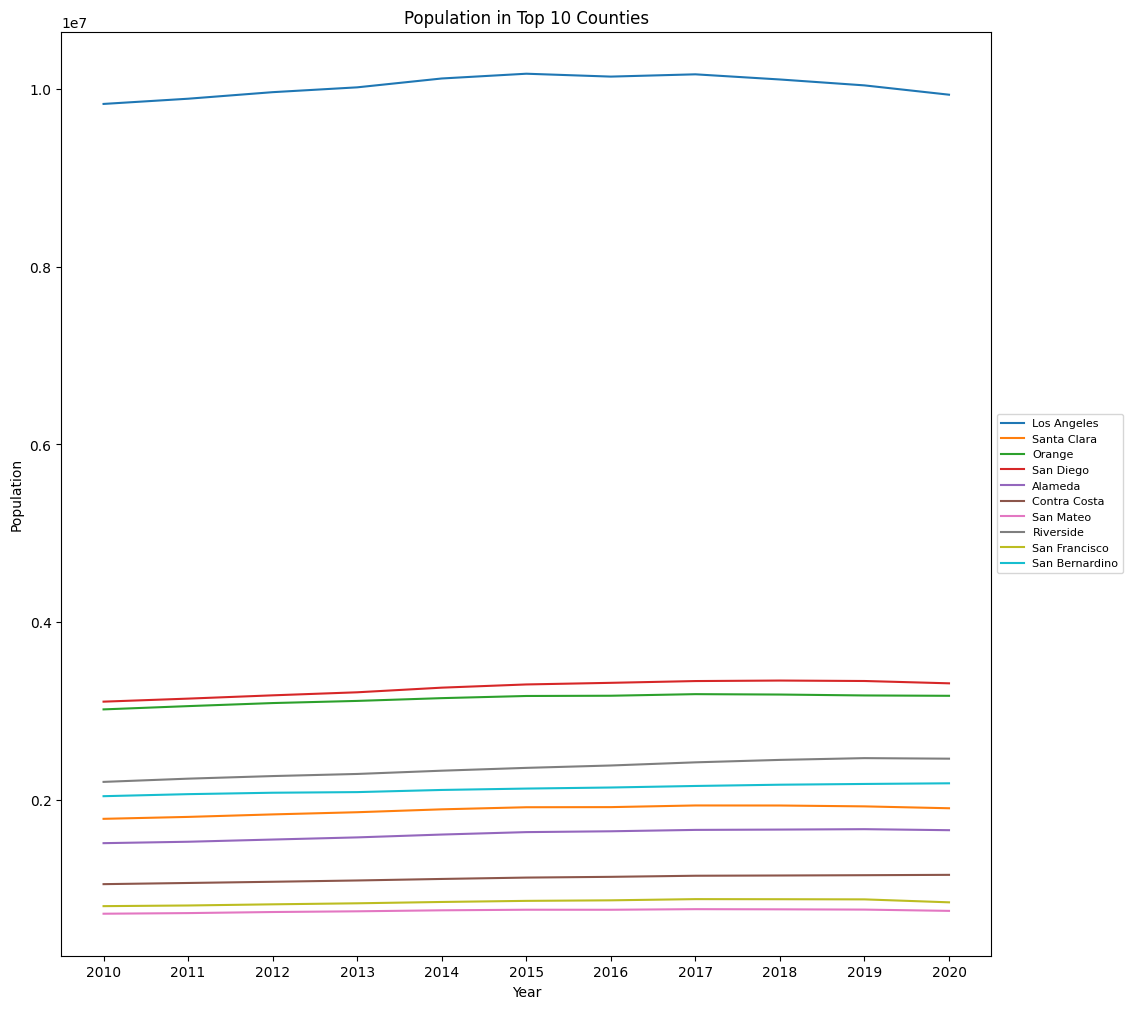

In [64]:
# Set the figure size
plt.figure(figsize=(12, 12))

x_labels = [str(year) for year in range(2010, 2021)]
# Plotting the line chart for population
for county_name in top_10_county_names:
    row = df_extra[df_extra['County'].str.strip() == county_name]
    data = row.iloc[:, 1:12]  # Slice the columns for years 2010 to 2020
    plt.plot(x_labels, data.values.flatten(), label=county_name)

# Add labels and title to the chart
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population in Top 10 Counties')

# Customize the legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})

# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Population in Top 10 Counties.png', dpi=300, bbox_inches='tight')

# Show the line chart
plt.show()


In [65]:
df_extra

,County,2010_x,2011_x,2012_x,2013_x,2014_x,2015_x,2016_x,2017_x,2018_x,2019_x,2020_x,2021_x,2010_y,2011_y,2012_y,2013_y,2014_y,2015_y,2016_y,2017_y,2018_y,2019_y,2020_y,2021_y
0,Alameda,1513952,1529875,1554720,1578891,1610921,1638215,1647704,1663190,1666753,1671329,1659942.5,1648556,33961,33888,35379,36268,36977,39413,42376,44912,48595,51727,53623.5,55520
1,Butte,220072,220266,221539,222090,224241,225411,226864,229294,231256,219186,213747.5,208309,23404,21951,23067,23744,25842,23867,25938,28038,28915,34250,34724.0,35198
2,Contra Costa,1052827,1066096,1079597,1094205,1111339,1126745,1135127,1147439,1150215,1153526,1157469.5,1161413,37818,36274,37000,38344,40141,40955,43120,45776,48968,52021,53451.5,54882
3,El Dorado,181194,180938,180561,181737,183087,184452,185625,188987,190678,192843,193032.0,193221,34393,31855,33740,33107,35680,38082,39284,38385,43133,46669,49461.0,52253
4,Fresno,933248,942904,947895,955272,965974,974861,979915,989255,994400,999101,1006341.0,1013581,20329,19004,19010,19682,20170,21079,22518,23670,23834,25260,27013.0,28766
5,Humboldt,134794,134761,134827,134493,134809,135727,136646,136754,136373,135558,135934.0,136310,24025,22084,22511,22432,22637,24232,26990,27230,27406,32537,32070.0,31603
6,Imperial,175234,177057,176948,176584,179091,180191,180883,182830,181827,181215,180533.0,179851,16395,16238,14833,16107,16226,15757,17180,18521,16920,18800,19376.0,19952
7,Kern,842207,851710,856158,864124,874589,882176,884788,893119,896764,900202,908937.5,917673,20100,19048,19738,19590,20488,21775,21313,21346,22778,24524,25012.0,25500
8,Kings,153174,153765,151364,150960,150269,150965,149785,150101,151366,152940,153191.5,153443,17875,18028,18619,17948,17378,20377,20471,20825,22628,22979,22809.5,22640
9,Lake,64771,64323,63983,63860,64184,64591,64116,64246,64382,64386,66576.0,68766,21531,21971,19347,20711,20798,21486,25347,27170,29537,28056,30479.5,32903


C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error for Los Angeles: 514549949.4953322
Mean Absolute Error for Los Angeles: 21884.204864501953
R^2 Score for Los Angeles: -7.9993600361333765


C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error for Santa Clara: 245252274.55715343
Mean Absolute Error for Santa Clara: 14275.491571813822
R^2 Score for Santa Clara: -123.59416440239474


C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error for Orange: 67263278.15406615
Mean Absolute Error for Orange: 6688.574954986572
R^2 Score for Orange: -2.1248967418681364


C:\Users\guota\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean Squared Error for San Diego: 25270554.487249266
Mean Absolute Error for San Diego: 4380.096418380737
R^2 Score for San Diego: -0.7344846128267961
Mean Squared Error for Alameda: 99447422.98882936
Mean Absolute Error for Alameda: 8843.232584953308
R^2 Score for Alameda: -34.7867561420515
Mean Squared Error for Contra Costa: 7466827.411762928
Mean Absolute Error for Contra Costa: 2191.3205742836
R^2 Score for Contra Costa: -2.038932222965155
Mean Squared Error for San Mateo: 23239197.778863396
Mean Absolute Error for San Mateo: 4389.103735744953
R^2 Score for San Mateo: -15.889823369420512
Mean Squared Error for Riverside: 10858204.167549573
Mean Absolute Error for Riverside: 2489.52787232399
R^2 Score for Riverside: -1.8880345556357967
Mean Squared Error for San Francisco: 91258.78272731026
Mean Absolute Error for San Francisco: 287.82992282509804
R^2 Score for San Francisco: 0.9404085083711065
Mean Squared Error for San Bernardino: 6143453.589512235
Mean Absolute Error for San Ber

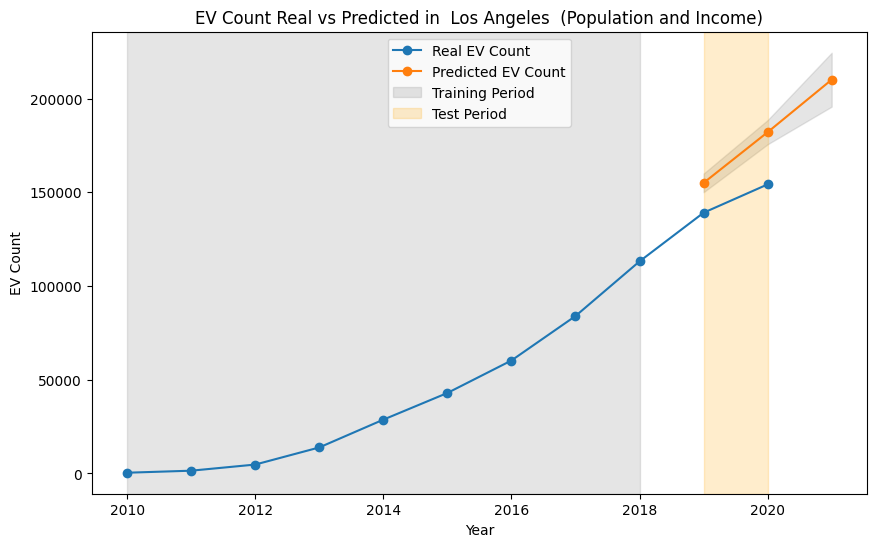

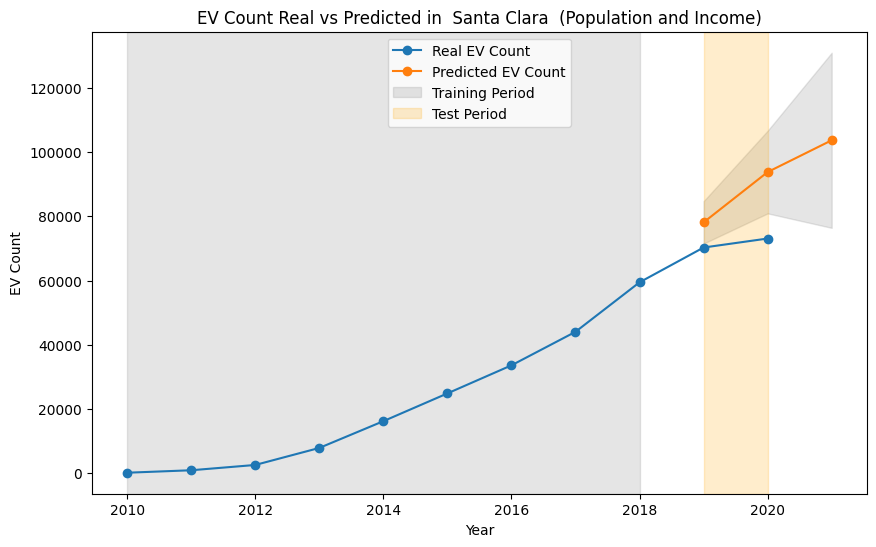

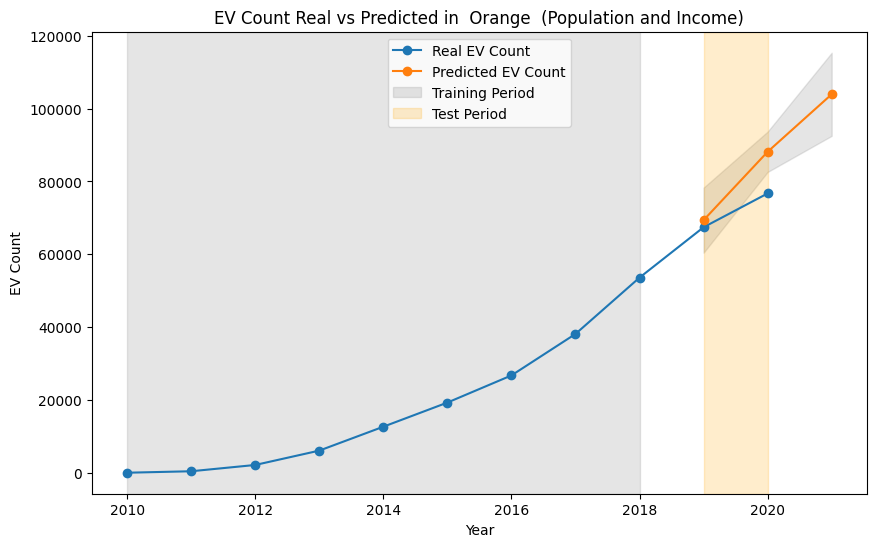

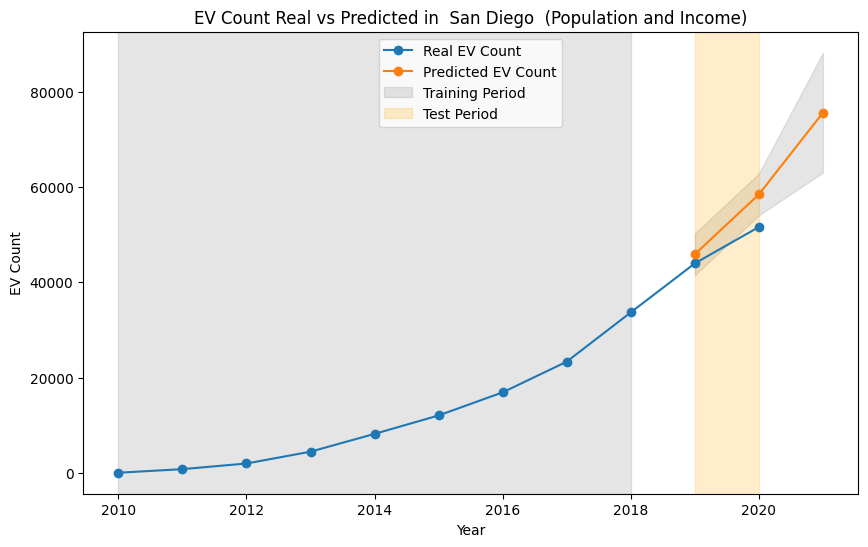

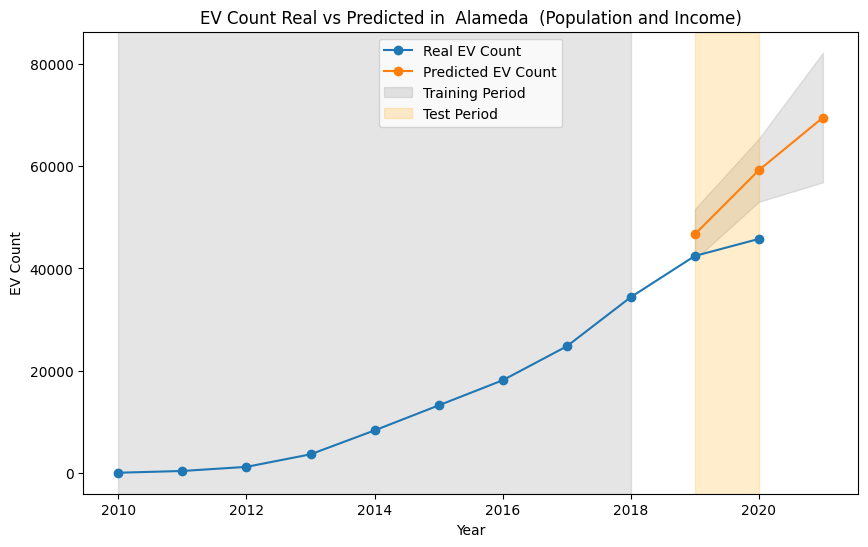

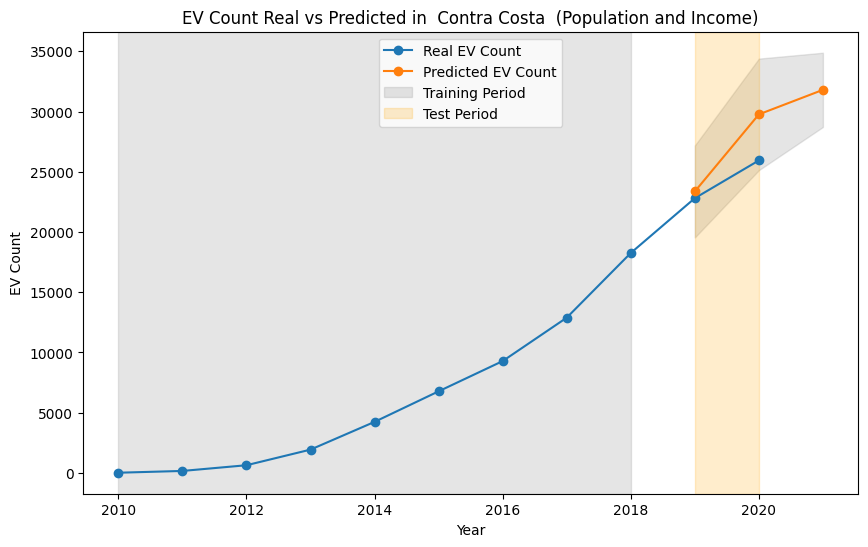

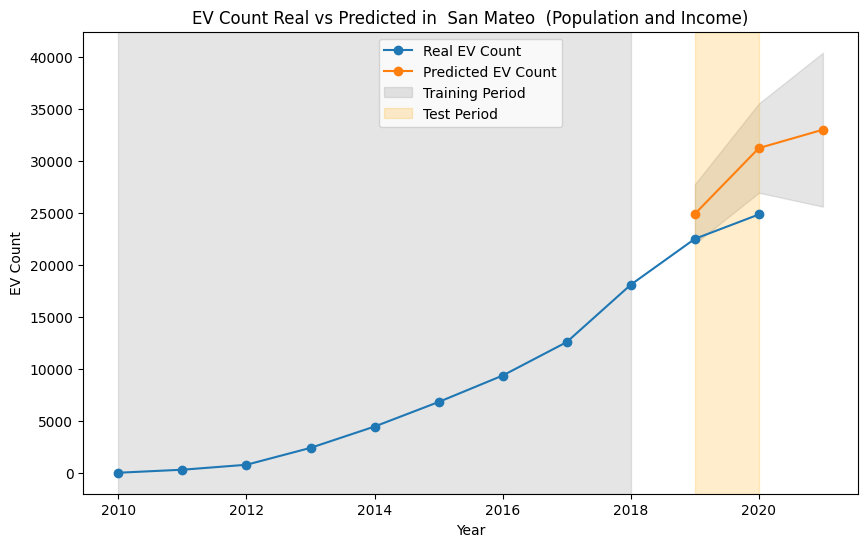

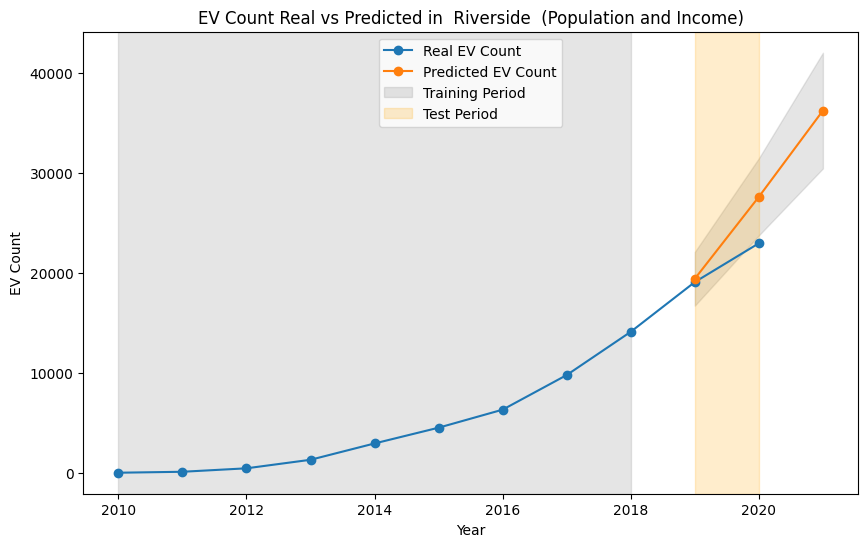

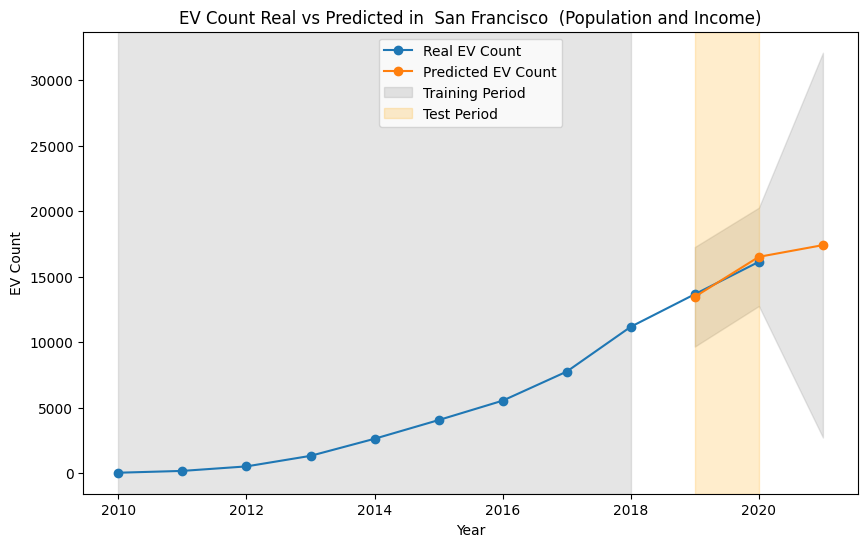

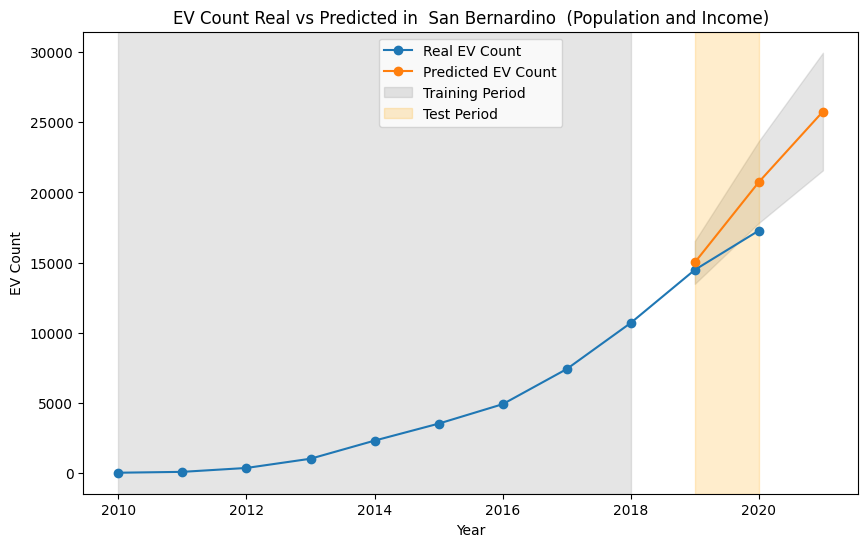

In [66]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


forecast_df = pd.DataFrame()

for county_name, county_index in zip(top_10_county_names, top_10_county_index):
    # List of years to consider for the lags
    years = [str(year) for year in range(2010, 2021)]
    # # Convert column names to strings using astype()
    finalMergedData.columns = finalMergedData.columns.astype(str)
    # Use the name of county'
    #county_index = 18
    #county_name = finalMergedData.loc[county_index, 'NAME']
    # Extract the specific row for the county
    county_data = finalMergedData.loc[finalMergedData['County'] == county_name, years]
    neighbors = W.neighbors[county_index]
    index_to_name = {i: name for i, name in enumerate(finalMergedData['County'])}
    neighbor_names = [index_to_name[i] for i in neighbors]
    spatial_feature = np.mean([finalMergedData.loc[finalMergedData['County'] == neighbor, years].values 
                               for neighbor in neighbor_names], axis=0)
    lag_years = 3

    # Convert the county_data and spatial_feature to lists
    county_data_list = list(county_data.values.flatten())
    spatial_feature_list = list(spatial_feature.flatten())

    #  Create lagged lists
    lagged_data = {'Year': years[lag_years:]}
    for i in range(lag_years, 0, -1):
        lagged_data[f'EV count (t-{i})'] = county_data_list[lag_years-i:-i or None]
        lagged_data[f'Avg. neighboring EV count (t-{i})'] = spatial_feature_list[lag_years-i:-i or None]
    lagged_data['EV count (t)'] = county_data_list[lag_years:]

    df = pd.DataFrame(lagged_data)

    # Extract the data from the 11th row to a new array
    # (remember that Python uses 0-based indexing, so the 11th row would have index 10)
    # Assuming your DataFrame is named 'df_extra'

    # Find the row index based on the county name
    population_index = df_extra[df_extra['County'].str.strip() == county_name].index
    PopulationIncomeData = df_extra.iloc[population_index[0], 1:].values
    # Define the years
    years = np.array(list(range(2010, 2022)) * 2)

    # Split the data into two arrays
    population_data = PopulationIncomeData[:11]
    income_data = PopulationIncomeData[12:23]

    # Reshape the arrays
    population = np.column_stack((population_data))
    income = np.column_stack((income_data))
    #  Convert the population and income to lists
    population_list = list(population.flatten())
    income_list = list(income.flatten())

    # Create lagged lists for population and income
    for i in range(lag_years, 0, -1):
        lagged_data[f'Population (t-{i})'] = population_list[lag_years-i:-i or None]
        lagged_data[f'Income (t-{i})'] = income_list[lag_years-i:-i or None]

    # Add the population and income at time t to the dataframe
    lagged_data['Population (t)'] = population_list[lag_years:]
    lagged_data['Income (t)'] = income_list[lag_years:]

    # Create a dataframe from the lagged data
    df = pd.DataFrame(lagged_data)
    # Select features and target
    X2 = df[['EV count (t-3)', 'EV count (t-2)', 'EV count (t-1)', 
            'Avg. neighboring EV count (t-3)', 'Avg. neighboring EV count (t-2)', 
            'Avg. neighboring EV count (t-1)','Population (t-3)','Population (t-2)','Population (t-1)','Income (t-3)','Income (t-2)','Income (t-2)']].values
    y2 = df['EV count (t)'].values

    # Select training and testing data
    X2_train, y2_train = X2[:-2], y2[:-2]  # all but the last two data points
    X2_test, y2_test = X2[-2:], y2[-2:]  # only the last two data points
    # Fit the GPR model
    gpr2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10).fit(X2_train, y2_train)
    # Predict the test set results
    y2_pred, sigma2_test = gpr2.predict(X2_test, return_std=True)

    # Calculate the mean squared error of the predictions

    mse = mean_squared_error(y2_test, y2_pred)
    print(f"Mean Squared Error for {county_name}: {mse}")

    # Calculate the mean absolute error of the predictions

    mae = mean_absolute_error(y2_test, y2_pred)
    print(f"Mean Absolute Error for {county_name}: {mae}")

    # Calculate the r2 score of the predictions

    r2 = r2_score(y2_test, y2_pred)
    print(f"R^2 Score for {county_name}: {r2}")

    # Let's print the actual and predicted values side by side
    comparison = pd.DataFrame({'Actual': y2_test, 'Predicted': y2_pred})

    # Define the feature vector for 2021
    X2_2021 = np.array([[county_data['2018'].values[0], 
                        county_data['2019'].values[0], 
                        county_data['2020'].values[0], 
                        spatial_feature[0][-3], 
                        spatial_feature[0][-2], 
                        spatial_feature[0][-1],
                        population[0][-3],
                        population[0][-2],
                        population[0][-1],
                        income[0][-3],
                        income[0][-2],
                        income[0][-1]]])

    # Predict for 2021
    y_pred2_2021, sigma2_2021 = gpr2.predict(X2_2021, return_std=True)

    # Flatten the y_pred_2021 array to a 1D array
    y_pred2_2021_flat = y_pred2_2021.flatten()
    

    forecast_df[county_name] = y_pred2_2021_flat
    
    #  Concatenate the predictions
    y_pred2 = np.concatenate((y2_pred, y_pred2_2021_flat))

    # Flatten the sigma_2021 array to a 1D array
    sigma2_2021_flat = sigma2_2021.flatten()

    #  Concatenate the standard deviations
    sigma2 = np.concatenate((sigma2_test, sigma2_2021_flat))


    years_extended = np.append(years, ['2021'])



# Define the years
    years = list(range(2010, 2022))  # Extend to 2022 for including the prediction for 2021

# Define the real EV count
    real2_count = list(county_data.values.flatten())

# Create a new list that includes the predictions for 2019, 2020, and 2021
    predicted2_count = [None]*9 + list(y_pred2) #+ [y_pred_2021.item()]  # Use .item() to get the value from the 1-element array

# Also define the confidence intervals
    ci2_upper = [None]*9 + list(y_pred2 + 1.96*sigma2)
    ci2_lower = [None]*9 + list(y_pred2 - 1.96*sigma2)

# Define the years where predictions were made
    pred_years = years[-len(sigma):]  # Only take the years where predictions exist

# Create the plot
    plt.figure(figsize=(10,6))

# Plot the real data
    plt.plot(years[:-1], real2_count, label='Real EV Count', marker='o')

# Plot the predicted data
    plt.plot(years, predicted2_count, label='Predicted EV Count', marker='o')

# Plot the confidence intervals for the predicted years
    plt.fill_between(pred_years, ci2_lower[-len(sigma):], ci2_upper[-len(sigma):], color='gray', alpha=0.2)

# Highlight the training and testing periods
    plt.axvspan(2010, 2018, color='gray', alpha=0.2, label='Training Period')
    plt.axvspan(2019, 2020, color='orange', alpha=0.2, label='Test Period')

# Add a legend
    plt.legend()

# Add labels and title
    plt.xlabel('Year')
    plt.ylabel('EV Count')
    plt.title('EV Count Real vs Predicted in  ' + county_name + '  (Population and Income)')

# Save the plot as a high-resolution image (e.g., PNG or PDF)
    plt.savefig('EV Count Real vs Predicted in ' + county_name.replace(" ", "_") + ' (Population and Income).png', dpi=300, bbox_inches='tight')

# Show the plot
   #  plt.show()

In [67]:
forecast_df

,Los Angeles,Santa Clara,Orange,San Diego,Alameda,Contra Costa,San Mateo,Riverside,San Francisco,San Bernardino
0,210107.172852,103712.581019,103921.797894,75625.200821,69543.639382,31798.1392,33042.415561,36225.154706,17408.367203,25772.128251


# ***Chargers***

In [68]:
chargerData

,County,Q2 2020-Public Level 1,Q2 2020-Shared Private Level 1,Q2 2020-Public Level 2,Q2 2020-Shared Private Level 2,Q2 2020-Public DC Fast,Q2 2020-Shared Private DC Fast,Q2 2020-Total,Q3 2020-Public Level 1,Q3 2020-Shared Private Level 1,Q3 2020-Public Level 2,Q3 2020-Shared Private Level 2,Q3 2020-Public DC Fast,Q3 2020-Shared Private DC Fast,Q3 2020-Total,Q4 2020-Public Level 1,Q4 2020-Shared Private Level 1,Q4 2020-Public Level 2,Q4 2020-Shared Private Level 2,Q4 2020-Public DC Fast,Q4 2020-Shared Private DC Fast,Q4 2020-Total,Q1 2021-Public Level 1,Q1 2021-Shared Private Level 1,Q1 2021-Public Level 2,Q1 2021-Shared Private Level 2,Q1 2021-Public DC Fast,Q1 2021-Shared Private DC Fast,Q1 2021-Total,Q2 2021-Public Level 1,Q2 2021-Shared Private Level 1,Q2 2021-Public Level 2,Q2 2021-Shared Private Level 2,Q2 2021-Public DC Fast,Q2 2021-Shared Private DC Fast,Q2 2021-Total,Q3 2021-Public Level 1,Q3 2021-Shared Private Level 1,Q3 2021-Public Level 2,Q3 2021-Shared Private Level 2,Q3 2021-Public DC Fast,Q3 2021-Shared Private DC Fast,Q3 2021-Total,Q4 2021-Public Level 1,Q4 2021-Shared Private Level 1,Q4 2021-Public Level 2,Q4 2021-Shared Private Level 2,Q4 2021-Public DC Fast,Q4 2021-Shared Private DC Fast,Q4 2021-Total,Q1 2022-Public Level 1,Q1 2022-Shared Private Level 1,Q1 2022-Public Level 2,Q1 2022-Shared Private Level 2,Q1 2022-Public DC Fast,Q1 2022-Shared Private DC Fast,Q1 2022-Total,Q2 2022-Public Level 1,Q2 2022-Shared Private Level 1,Q2 2022-Public Level 2,Q2 2022-Shared Private Level 2,Q2 2022-Public DC Fast,Q2 2022-Shared Private DC Fast,Q2 2022-Total,Q3 2022-Public Level 1,Q3 2022-Shared Private Level 1,Q3 2022-Public Level 2,Q3 2022-Shared Private Level 2,Q3 2022-Public DC Fast,Q3 2022-Shared Private DC Fast,Q3 2022-Total,Q4 2022-Public Level 1,Q4 2022-Shared Private Level 1,Q4 2022-Public Level 2,Q4 2022-Shared Private Level 2,Q4 2022-Public DC Fast,Q4 2022-Shared Private DC Fast,Q4 2022-Total
0,Alameda,14,14,1274,1398,258,32,2990,14,14,1288,1460,268,38,3082,14,14,1519,1472,296,38,3353,14,63,1635,1497,292,43,3544,14,63,1633,1497,310,43,3560,14,66,1633,1554,315,43,3625,6,70,1671,1583,332,35,3697,0,70,1671,2080,347,34,5051,0,70,1724,2104,366,34,5139,0,70,1465,2334,375,38,4282,4,66,1473,2465,385,37,4430
1,Alpine,0,0,12,0,0,0,12,0,0,12,1,0,0,13,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,1,0,0,15,0,0,14,0,0,0,14,0,0,18,0,0,0,18,0,0,16,0,0,0,16,0,0,16,0,0,0,16,0,0,6,0,0,0,6
2,Amador,0,0,23,6,0,0,29,0,0,23,7,0,0,30,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,7,8,0,40,0,0,25,6,8,0,39,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,25,0,8,0,33,0,0,26,0,8,0,34
3,Butte,6,0,32,20,16,0,74,6,0,32,20,16,2,76,6,0,30,22,16,2,76,6,0,36,22,16,2,82,6,0,44,22,17,2,91,6,0,41,22,21,2,92,6,0,41,23,24,0,94,6,0,41,45,27,1,132,6,0,66,46,27,1,158,6,0,59,46,27,1,139,6,0,59,55,26,0,146
4,Calaveras,0,0,7,0,0,0,7,0,0,7,0,0,0,7,0,0,7,0,0,0,7,0,0,7,0,12,0,19,0,0,7,0,12,0,19,0,2,7,0,12,0,21,0,2,7,0,12,0,21,0,2,7,0,12,0,21,0,2,9,0,12,0,23,0,2,9,0,12,0,23,0,2,11,0,12,0,25
5,Colusa,0,0,16,2,10,0,28,0,0,16,2,10,0,28,0,0,16,2,10,0,28,0,0,16,2,10,0,28,0,0,18,2,10,0,30,0,0,18,2,14,0,34,0,0,18,2,18,0,38,0,0,18,0,18,0,36,0,0,18,0,18,0,36,0,0,16,0,18,0,34,0,0,14,2,18,0,34
6,Contra Costa,8,0,469,422,167,2,1068,8,0,490,656,164,7,1325,8,0,514,658,168,7,1355,7,2,574,660,205,7,1455,7,2,582,660,203,7,1461,7,2,599,660,208,7,1483,3,2,600,599,245,2,1451,2,2,589,442,252,1,1715,2,2,575,445,245,1,1699,0,2,630,608,251,4,1495,0,2,633,606,254,8,1503
7,Del Norte,0,0,10,0,20,0,30,0,0,10,0,20,0,30,0,0,10,0,20,0,30,0,0,10,0,15,0,25,0,0,10,0,15,0,25,0,0,12,0,17,0,29,0,0,12,0,17,0,29,0,0,12,1,17,2,32,0,0,12,1,17,2,32,0,0,14,1,22,2,39,0,0,14,1,22,2,39
8,El Dorado,1,0,109,5,35,0,150,1,0,117,6,35,1,160,1,0,122,6,43,1,173,1,0,122,6,37,1,167,1,0,124,6,45,1,177,1,0,124,6,49,1,181,1,0,124,5,49,0,179,1,0,124,0,48,0,173,1,0,144,0,48,0,193,1,0,140,4,48,1,194,1,0,138,4,45,1,189
9,Fresno,8,0,355,238,77,6,684,8,0,343,333,81,14,779,8,0,391,333,175,14,921,8,1,541,346,183,13,1092

In [69]:
# Define the columns of interest (charger counts)
charger_columns = chargerData.columns[[7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77]]

# Select rows corresponding to the top 10 counties
top_10_chargerData = chargerData[chargerData['County'].isin(top_10_county_names)]

# Select only the columns of interest
top_10_chargerData = top_10_chargerData.loc[:, ['County'] + list(charger_columns)]


In [70]:
top_10_chargerData

,County,Q2 2020-Total,Q3 2020-Total,Q4 2020-Total,Q1 2021-Total,Q2 2021-Total,Q3 2021-Total,Q4 2021-Total,Q1 2022-Total,Q2 2022-Total,Q3 2022-Total,Q4 2022-Total
0,Alameda,2990,3082,3353,3544,3560,3625,3697,5051,5139,4282,4430
6,Contra Costa,1068,1325,1355,1455,1461,1483,1451,1715,1699,1495,1503
18,Los Angeles,16770,18509,19236,19872,20193,20520,20950,23903,24615,25685,27015
29,Orange,4799,4886,5242,5381,5477,5657,5852,5003,5189,5214,5383
32,Riverside,1306,1360,1464,1422,1441,1495,1548,1441,1493,1508,1635
35,San Bernardino,999,1297,1338,1395,1415,1478,1367,1424,1560,1615,1682
36,San Diego,6073,6760,6874,7170,7199,7278,10080,6551,7074,7358,7735
37,San Francisco,1264,1384,1505,1609,1671,1840,1630,1519,1575,1436,1952
40,San Mateo,3617,3758,4070,4282,4459,4701,4511,4688,4799,4436,4557
42,Santa Clara,14164,14913,15406,16119,16202,16498,15987,16831,16981,16227,17621


<Figure size 1200x1200 with 0 Axes>

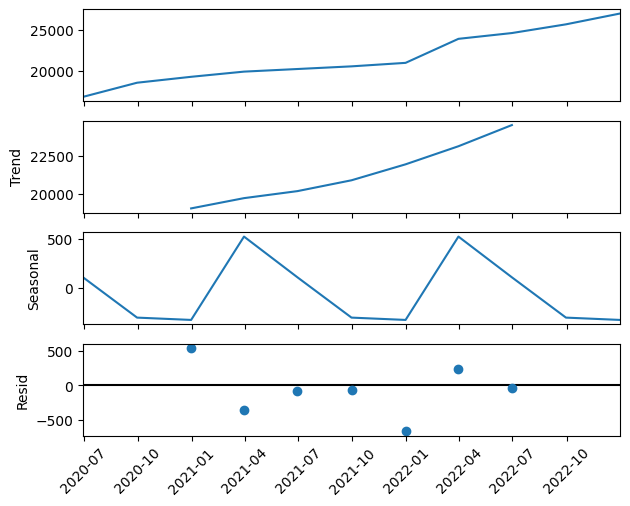

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# Define the data you want to use for the forecast
la_data = top_10_chargerData[top_10_chargerData['County'] == 'Los Angeles'].iloc[:, 1:].values.flatten()

# Create a date range for the data, using pandas DatetimeIndex instead of Period
dates = pd.date_range(start='2020Q2', periods=len(la_data), freq='Q')

# Create a time series with the data and the dates
la_data_series = pd.Series(la_data, index=dates)

# Perform the seasonal decomposition
decomposition = seasonal_decompose(la_data_series, period=4)
plt.figure(figsize=(12, 12))

# Plot the components
decomposition.plot()
plt.xticks(rotation=45)
# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Seasonality check for the Number of Chargers in Los Angeles County', dpi=300, bbox_inches='tight')
                
plt.show()




Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[2] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[2] intercept   : AIC=165.421, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[2] intercept   : AIC=168.770, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[2] intercept   : AIC=168.623, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[2]             : AIC=173.538, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[2] intercept   : AIC=167.277, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[2] intercept   : AIC=167.128, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[2] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[2] intercept   : AIC=167.207, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[2] intercept   : AIC=166.814, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[2] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[2] intercept
Total fit time: 0.675 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   11
Model:             

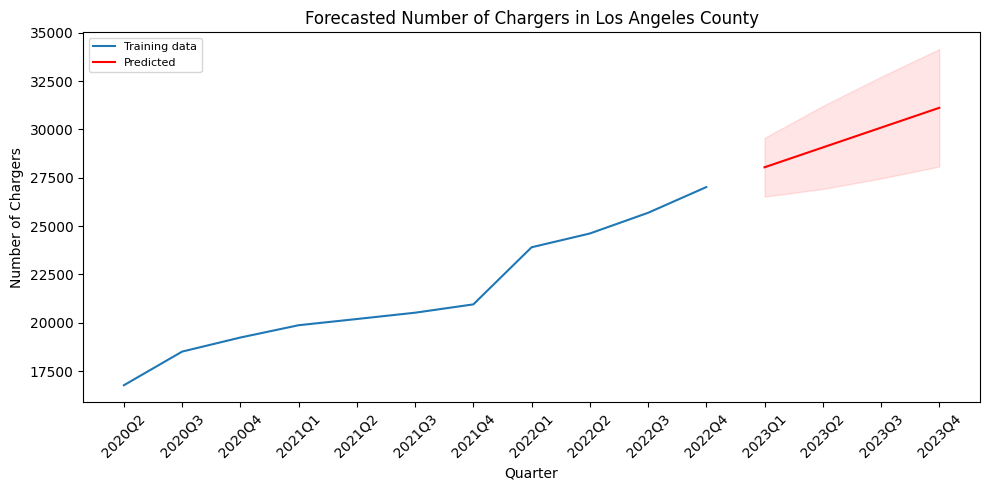

In [72]:
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt

# Define the data you want to use for the forecast
la_data = top_10_chargerData[top_10_chargerData['County'] == 'Los Angeles'].iloc[:, 1:].values.flatten()

# Fit auto_arima function to the full dataset
stepwise_fit = pm.auto_arima(la_data, start_p=1, start_q=1, 
                             max_p=3, max_q=3, 
                             seasonal=True, D=0, 
                             trace=True, m=2, 
                             error_action='ignore', 
                             suppress_warnings=True, 
                             stepwise=True)

# Print the summary
print(stepwise_fit.summary())

# Predict the next 4 quarters (Q1 2023 to Q4 2023)
n_periods = 4
forecast, conf_int = stepwise_fit.predict(n_periods=n_periods, return_conf_int=True)

# Create a plot
plt.figure(figsize=(10, 5))

# Generate the quarter labels
quarters = pd.period_range('2020Q2', periods=len(la_data)+n_periods, freq='Q')

# Convert Period objects to strings
quarters_str = quarters.strftime('%YQ%q')

# Plot the training data
plt.plot(quarters_str[:len(la_data)], la_data, label='Training data')

# Plot the forecasts
plt.plot(quarters_str[len(la_data):], forecast, color='red', label='Predicted')

# Plot the confidence intervals
plt.fill_between(quarters_str[len(la_data):], conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.1)

plt.title('Forecasted Number of Chargers in Los Angeles County')
plt.xlabel('Quarter')
plt.ylabel('Number of Chargers')
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=8)
plt.tight_layout()
# Save the plot as a high-resolution image (e.g., PNG or PDF)
plt.savefig('Forecasted Number of Chargers in Los Angeles County', dpi=300, bbox_inches='tight')
plt.show()


# ***END***